Imports:

In [278]:
from math import sin
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback
from keras.layers import SimpleRNN, TimeDistributed, Reshape, LeakyReLU
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import tensorflow as tf

This is a toy problem, we want to model a sign function and subtraction with memory.

1. Given a number as input, predict its sign (ex. -0.001 -> -1; 0.34 -> 1)
2. Given two numbers at once as input, subtract the second from the first in pair (ex. [0.34, 0.15] -> 0.19)
3. Given two numbers as input treated like a time series, return the current value and previous step (ex. [0.34] -> [0, 0.34], [0.15] -> [0.34, 0.15])

Combine all above and learn sign from time series.
This will require at least 3 layers, at least 1 with memory.

          x
0  0.958924
1  0.961646
2  0.964276
3  0.966815
4  0.969261


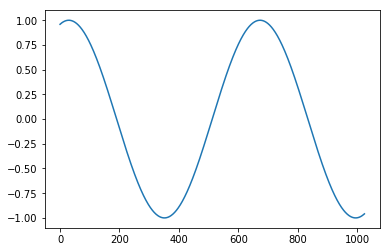

In [41]:
np.random.seed(42) #for reproducibility

x_vals = [sin(x) for x in np.linspace(-5,5,1026)] #make 1026 samples
x_vals = pd.DataFrame(x_vals, columns=['x'])
print(x_vals.head())
plt.plot(x_vals)

Prepare data:

windowed: 
 [[0.95892427 0.96164603]
 [0.96164603 0.96427626]
 [0.96427626 0.9668147 ]
 [0.9668147  0.96926113]
 [0.96926113 0.9716153 ]] 
 x: 
 1    0.961646
2    0.964276
3    0.966815
4    0.969261
Name: x, dtype: float64 
 y: 
 1   -1.0
2   -1.0
3   -1.0
4   -1.0
Name: y, dtype: float64 
matrix shapes: 
 (1024, 2) (1024,) (1024,)
          x   shifted    y      diff
0  0.958924  0.961646 -1.0 -0.002722
1  0.961646  0.964276 -1.0 -0.002630
2  0.964276  0.966815 -1.0 -0.002538
3  0.966815  0.969261 -1.0 -0.002446
4  0.969261  0.971615 -1.0 -0.002354


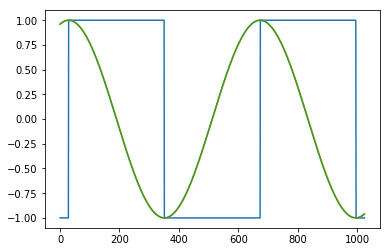

In [42]:
x_vals['shifted'] = x_vals['x'].shift(-1)
x_vals.dropna(inplace=True)
x_vals['y'] = np.sign(x_vals['x'] - x_vals['shifted']) 
x_vals['diff'] = x_vals['x'] - x_vals['shifted'] 

windowed = np.hstack((np.expand_dims(x_vals['x'],1), np.expand_dims(x_vals['shifted'],1)))

print("windowed: \n", windowed[:5],
      '\n x: \n', x_vals['x'][1:5],
      '\n y: \n', x_vals['y'][1:5],
      "\nmatrix shapes: \n", windowed[:-1].shape, x_vals['x'][1:].shape, x_vals['y'][1:].shape)
print(x_vals.head())
plt.plot(x_vals['y'])
plt.plot(windowed)

# Learn sign from number:

Prepare data (train and validation):

In [196]:
x_train = x_vals['diff'][1:897]
y_train = x_vals['y'][1:897]

x_val = x_vals['diff'][897:]
y_val = x_vals['y'][897:]


Prepare candidate model (single perceptron with sign activation):

In [197]:
sign_model = Sequential()
sign_model.add(Dense(1, input_shape=(1,), activation = tf.sign))
sign_model.compile(loss = "mean_squared_error", 
              optimizer = 'adam')
sign_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


See randomly generated weights:

In [198]:
weight, bias = sign_model.get_weights()
print("Perceptron weight: ", weight)
print("Perceptron bias: ", bias)

Perceptron weight:  [[0.21433055]]
Perceptron bias:  [0.]


If weight is >0, then the model will be perfect. To try if it learns, we will initialize weight to arbitrary negative value:

In [199]:
sign_model.set_weights((np.array(-0.5).reshape((1,1)), bias))

In [200]:
weight, bias = sign_model.get_weights()
print("Perceptron weight: ", weight)
print("Perceptron bias: ", bias)

Perceptron weight:  [[-0.5]]
Perceptron bias:  [0.]


Train model:

In [201]:
sign_model.fit(x_train, 
              y_train, 
              batch_size = 128,
              epochs = 10,
              #validation_split = 0,
              shuffle=True,
              verbose=1,
              validation_data=(x_val,y_val))

Train on 896 samples, validate on 128 samples
Epoch 1/10
896/896 [==============================] - 1s 663us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 2/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 3/10
896/896 [==============================] - 0s 0us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 4/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 5/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 6/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 7/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 8/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 9/10
896/896 [==============================] - 0s 17us/step - loss: 4.0000 - val_loss: 4.0000
Epoch 10/10
896/896 [========================

Model does not learn anything due to sign function shape, gradient is zero!
Let's replace sign with tanh:

In [202]:
sign_model = Sequential()
sign_model.add(Dense(1, input_shape=(1,), activation = 'tanh'))
sign_model.compile(loss = "mean_squared_error", 
              optimizer = 'adam')

sign_model.set_weights((np.array(-0.5).reshape((1,1)), bias))
sign_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Train again:

In [203]:
sign_model.fit(x_train, 
              y_train, 
              batch_size = 128,
              epochs = 10,
              #validation_split = 0,
              shuffle=True,
              verbose=1,
              validation_data=(x_val,y_val))

Train on 896 samples, validate on 128 samples
Epoch 1/10
896/896 [==============================] - 1s 942us/step - loss: 1.0051 - val_loss: 0.9962
Epoch 2/10
896/896 [==============================] - 0s 17us/step - loss: 1.0021 - val_loss: 0.9892
Epoch 3/10
896/896 [==============================] - 0s 17us/step - loss: 0.9994 - val_loss: 0.9822
Epoch 4/10
896/896 [==============================] - 0s 17us/step - loss: 0.9965 - val_loss: 0.9756
Epoch 5/10
896/896 [==============================] - 0s 35us/step - loss: 0.9942 - val_loss: 0.9687
Epoch 6/10
896/896 [==============================] - 0s 17us/step - loss: 0.9917 - val_loss: 0.9622
Epoch 7/10
896/896 [==============================] - 0s 35us/step - loss: 0.9893 - val_loss: 0.9560
Epoch 8/10
896/896 [==============================] - 0s 35us/step - loss: 0.9871 - val_loss: 0.9499
Epoch 9/10
896/896 [==============================] - 0s 17us/step - loss: 0.9850 - val_loss: 0.9440
Epoch 10/10
896/896 [=======================

Training is really slow, adjust optimizer (change default learning rate from 0.001 to 0.1):

In [204]:
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False,clipvalue=0.5)
sign_model.compile(loss = "mean_squared_error", 
              optimizer = opt)

In [205]:
sign_model.fit(x_train, 
              y_train, 
              batch_size = 128,
              epochs = 10000,
              #validation_split = 0,
              shuffle=True,
              verbose=1,
              validation_data=(x_val,y_val))

Train on 896 samples, validate on 128 samples
Epoch 1/10000
896/896 [==============================] - 1s 767us/step - loss: 0.9676 - val_loss: 0.7680
Epoch 2/10000
896/896 [==============================] - 0s 17us/step - loss: 0.9535 - val_loss: 0.8868
Epoch 3/10000
896/896 [==============================] - 0s 17us/step - loss: 0.9422 - val_loss: 0.7690
Epoch 4/10000
896/896 [==============================] - 0s 35us/step - loss: 0.9380 - val_loss: 0.7986
Epoch 5/10000
896/896 [==============================] - 0s 17us/step - loss: 0.9259 - val_loss: 0.8358
Epoch 6/10000
896/896 [==============================] - 0s 35us/step - loss: 0.9165 - val_loss: 0.7687
Epoch 7/10000
896/896 [==============================] - 0s 17us/step - loss: 0.9126 - val_loss: 0.7950
Epoch 8/10000
896/896 [==============================] - 0s 35us/step - loss: 0.9023 - val_loss: 0.8197
Epoch 9/10000
896/896 [==============================] - 0s 17us/step - loss: 0.8935 - val_loss: 0.7748
Epoch 10/10000
89

896/896 [==============================] - 0s 35us/step - loss: 0.5174 - val_loss: 0.6254
Epoch 79/10000
896/896 [==============================] - 0s 17us/step - loss: 0.5131 - val_loss: 0.6461
Epoch 80/10000
896/896 [==============================] - 0s 17us/step - loss: 0.5121 - val_loss: 0.6137
Epoch 81/10000
896/896 [==============================] - 0s 17us/step - loss: 0.5064 - val_loss: 0.6241
Epoch 82/10000
896/896 [==============================] - 0s 0us/step - loss: 0.5062 - val_loss: 0.6274
Epoch 83/10000
896/896 [==============================] - 0s 17us/step - loss: 0.5015 - val_loss: 0.6035
Epoch 84/10000
896/896 [==============================] - 0s 17us/step - loss: 0.5019 - val_loss: 0.6385
Epoch 85/10000
896/896 [==============================] - 0s 17us/step - loss: 0.4942 - val_loss: 0.5908
Epoch 86/10000
896/896 [==============================] - 0s 17us/step - loss: 0.4914 - val_loss: 0.6428
Epoch 87/10000
896/896 [==============================] - 0s 18us/step 

Epoch 156/10000
896/896 [==============================] - 0s 17us/step - loss: 0.3376 - val_loss: 0.5018
Epoch 157/10000
896/896 [==============================] - 0s 0us/step - loss: 0.3330 - val_loss: 0.5232
Epoch 158/10000
896/896 [==============================] - 0s 17us/step - loss: 0.3308 - val_loss: 0.5030
Epoch 159/10000
896/896 [==============================] - 0s 0us/step - loss: 0.3296 - val_loss: 0.5074
Epoch 160/10000
896/896 [==============================] - 0s 17us/step - loss: 0.3279 - val_loss: 0.5014
Epoch 161/10000
896/896 [==============================] - 0s 0us/step - loss: 0.3265 - val_loss: 0.5032
Epoch 162/10000
896/896 [==============================] - 0s 17us/step - loss: 0.3252 - val_loss: 0.5050
Epoch 163/10000
896/896 [==============================] - 0s 0us/step - loss: 0.3234 - val_loss: 0.4983
Epoch 164/10000
896/896 [==============================] - 0s 17us/step - loss: 0.3224 - val_loss: 0.5050
Epoch 165/10000
896/896 [=========================

896/896 [==============================] - 0s 17us/step - loss: 0.2519 - val_loss: 0.4328
Epoch 234/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2516 - val_loss: 0.4434
Epoch 235/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2501 - val_loss: 0.4342
Epoch 236/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2496 - val_loss: 0.4401
Epoch 237/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2485 - val_loss: 0.4326
Epoch 238/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2481 - val_loss: 0.4369
Epoch 239/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2475 - val_loss: 0.4271
Epoch 240/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2468 - val_loss: 0.4406
Epoch 241/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2454 - val_loss: 0.4284
Epoch 242/10000
896/896 [==============================] - 0s 17us/

896/896 [==============================] - 0s 0us/step - loss: 0.2069 - val_loss: 0.3876
Epoch 311/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2064 - val_loss: 0.3823
Epoch 312/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2061 - val_loss: 0.4006
Epoch 313/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2044 - val_loss: 0.3817
Epoch 314/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2059 - val_loss: 0.3823
Epoch 315/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2051 - val_loss: 0.3967
Epoch 316/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2037 - val_loss: 0.3794
Epoch 317/10000
896/896 [==============================] - 0s 17us/step - loss: 0.2032 - val_loss: 0.3880
Epoch 318/10000
896/896 [==============================] - 0s 0us/step - loss: 0.2025 - val_loss: 0.3870
Epoch 319/10000
896/896 [==============================] - 0s 17us

896/896 [==============================] - 0s 17us/step - loss: 0.1768 - val_loss: 0.3491
Epoch 388/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1774 - val_loss: 0.3534
Epoch 389/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1763 - val_loss: 0.3493
Epoch 390/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1756 - val_loss: 0.3502
Epoch 391/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1761 - val_loss: 0.3511
Epoch 392/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1771 - val_loss: 0.3503
Epoch 393/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1759 - val_loss: 0.3538
Epoch 394/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1744 - val_loss: 0.3432
Epoch 395/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1753 - val_loss: 0.3531
Epoch 396/10000
896/896 [==============================] - 0s 17us

Epoch 465/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1555 - val_loss: 0.3173
Epoch 466/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1559 - val_loss: 0.3210
Epoch 467/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1559 - val_loss: 0.3255
Epoch 468/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1556 - val_loss: 0.3187
Epoch 469/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1543 - val_loss: 0.3204
Epoch 470/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1542 - val_loss: 0.3197
Epoch 471/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1540 - val_loss: 0.3179
Epoch 472/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1538 - val_loss: 0.3201
Epoch 473/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1568 - val_loss: 0.3137
Epoch 474/10000
896/896 [========================

896/896 [==============================] - 0s 0us/step - loss: 0.1419 - val_loss: 0.2970
Epoch 543/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1390 - val_loss: 0.2918
Epoch 544/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1390 - val_loss: 0.2947
Epoch 545/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1391 - val_loss: 0.3004
Epoch 546/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1387 - val_loss: 0.2916
Epoch 547/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1390 - val_loss: 0.2937
Epoch 548/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1380 - val_loss: 0.2927
Epoch 549/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1379 - val_loss: 0.2921
Epoch 550/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1375 - val_loss: 0.2938
Epoch 551/10000
896/896 [==============================] - 0s 17u

896/896 [==============================] - 0s 0us/step - loss: 0.1276 - val_loss: 0.2747
Epoch 620/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1256 - val_loss: 0.2710
Epoch 621/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1280 - val_loss: 0.2731
Epoch 622/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1262 - val_loss: 0.2698
Epoch 623/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1265 - val_loss: 0.2771
Epoch 624/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1258 - val_loss: 0.2700
Epoch 625/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1261 - val_loss: 0.2735
Epoch 626/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1259 - val_loss: 0.2710
Epoch 627/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1254 - val_loss: 0.2692
Epoch 628/10000
896/896 [==============================] - 0s 0us/

896/896 [==============================] - 0s 17us/step - loss: 0.1153 - val_loss: 0.2526
Epoch 697/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1156 - val_loss: 0.2558
Epoch 698/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1154 - val_loss: 0.2511
Epoch 699/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1151 - val_loss: 0.2546
Epoch 700/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1153 - val_loss: 0.2535
Epoch 701/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1145 - val_loss: 0.2506
Epoch 702/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1144 - val_loss: 0.2518
Epoch 703/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1147 - val_loss: 0.2540
Epoch 704/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1141 - val_loss: 0.2503
Epoch 705/10000
896/896 [==============================] - 0s 17u

896/896 [==============================] - 0s 0us/step - loss: 0.1057 - val_loss: 0.2354
Epoch 774/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1066 - val_loss: 0.2348
Epoch 775/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1055 - val_loss: 0.2353
Epoch 776/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1054 - val_loss: 0.2347
Epoch 777/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1058 - val_loss: 0.2368
Epoch 778/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1055 - val_loss: 0.2330
Epoch 779/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1055 - val_loss: 0.2359
Epoch 780/10000
896/896 [==============================] - 0s 0us/step - loss: 0.1049 - val_loss: 0.2340
Epoch 781/10000
896/896 [==============================] - 0s 17us/step - loss: 0.1047 - val_loss: 0.2337
Epoch 782/10000
896/896 [==============================] - 0s 0us/

Epoch 851/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0972 - val_loss: 0.2184
Epoch 852/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0972 - val_loss: 0.2178
Epoch 853/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0971 - val_loss: 0.2186
Epoch 854/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0970 - val_loss: 0.2202
Epoch 855/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0968 - val_loss: 0.2174
Epoch 856/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0970 - val_loss: 0.2172
Epoch 857/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0969 - val_loss: 0.2181
Epoch 858/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0968 - val_loss: 0.2169
Epoch 859/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0964 - val_loss: 0.2172
Epoch 860/10000
896/896 [========================

896/896 [==============================] - 0s 0us/step - loss: 0.0902 - val_loss: 0.2038
Epoch 929/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0899 - val_loss: 0.2035
Epoch 930/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0899 - val_loss: 0.2030
Epoch 931/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0895 - val_loss: 0.2037
Epoch 932/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0895 - val_loss: 0.2042
Epoch 933/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0895 - val_loss: 0.2026
Epoch 934/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0893 - val_loss: 0.2021
Epoch 935/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0894 - val_loss: 0.2044
Epoch 936/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0897 - val_loss: 0.2026
Epoch 937/10000
896/896 [==============================] - 0s 17us/

896/896 [==============================] - 0s 17us/step - loss: 0.0834 - val_loss: 0.1901
Epoch 1006/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0832 - val_loss: 0.1898
Epoch 1007/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0833 - val_loss: 0.1889
Epoch 1008/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0843 - val_loss: 0.1905
Epoch 1009/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0834 - val_loss: 0.1886
Epoch 1010/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0830 - val_loss: 0.1904
Epoch 1011/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0834 - val_loss: 0.1887
Epoch 1012/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0833 - val_loss: 0.1915
Epoch 1013/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0831 - val_loss: 0.1880
Epoch 1014/10000
896/896 [==============================]

Epoch 1082/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0776 - val_loss: 0.1769
Epoch 1083/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0772 - val_loss: 0.1769
Epoch 1084/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0785 - val_loss: 0.1824
Epoch 1085/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0787 - val_loss: 0.1769
Epoch 1086/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0772 - val_loss: 0.1766
Epoch 1087/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0772 - val_loss: 0.1780
Epoch 1088/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0775 - val_loss: 0.1758
Epoch 1089/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0773 - val_loss: 0.1773
Epoch 1090/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0771 - val_loss: 0.1771
Epoch 1091/10000
896/896 [============

Epoch 1159/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0720 - val_loss: 0.1673
Epoch 1160/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0724 - val_loss: 0.1660
Epoch 1161/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0719 - val_loss: 0.1648
Epoch 1162/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0720 - val_loss: 0.1655
Epoch 1163/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0716 - val_loss: 0.1651
Epoch 1164/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0719 - val_loss: 0.1647
Epoch 1165/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0719 - val_loss: 0.1643
Epoch 1166/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0726 - val_loss: 0.1672
Epoch 1167/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0718 - val_loss: 0.1641
Epoch 1168/10000
896/896 [================

Epoch 1236/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0680 - val_loss: 0.1580
Epoch 1237/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0671 - val_loss: 0.1543
Epoch 1238/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0669 - val_loss: 0.1540
Epoch 1239/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0673 - val_loss: 0.1554
Epoch 1240/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0667 - val_loss: 0.1542
Epoch 1241/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0668 - val_loss: 0.1537
Epoch 1242/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0673 - val_loss: 0.1537
Epoch 1243/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0666 - val_loss: 0.1534
Epoch 1244/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0665 - val_loss: 0.1535
Epoch 1245/10000
896/896 [=============

896/896 [==============================] - 0s 17us/step - loss: 0.0628 - val_loss: 0.1447
Epoch 1313/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0634 - val_loss: 0.1444
Epoch 1314/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0627 - val_loss: 0.1463
Epoch 1315/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0626 - val_loss: 0.1448
Epoch 1316/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0623 - val_loss: 0.1441
Epoch 1317/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0625 - val_loss: 0.1441
Epoch 1318/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0624 - val_loss: 0.1442
Epoch 1319/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0628 - val_loss: 0.1437
Epoch 1320/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0628 - val_loss: 0.1472
Epoch 1321/10000
896/896 [==============================

Epoch 1389/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0587 - val_loss: 0.1365
Epoch 1390/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0586 - val_loss: 0.1357
Epoch 1391/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0586 - val_loss: 0.1360
Epoch 1392/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0591 - val_loss: 0.1361
Epoch 1393/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0587 - val_loss: 0.1354
Epoch 1394/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0597 - val_loss: 0.1359
Epoch 1395/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0596 - val_loss: 0.1349
Epoch 1396/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0581 - val_loss: 0.1363
Epoch 1397/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0587 - val_loss: 0.1355
Epoch 1398/10000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0554 - val_loss: 0.1278
Epoch 1466/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0550 - val_loss: 0.1277
Epoch 1467/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0553 - val_loss: 0.1283
Epoch 1468/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0548 - val_loss: 0.1272
Epoch 1469/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0549 - val_loss: 0.1271
Epoch 1470/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0551 - val_loss: 0.1284
Epoch 1471/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0552 - val_loss: 0.1269
Epoch 1472/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0550 - val_loss: 0.1268
Epoch 1473/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0550 - val_loss: 0.1275
Epoch 1474/10000
896/896 [=============================

Epoch 1542/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0532 - val_loss: 0.1201
Epoch 1543/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0522 - val_loss: 0.1239
Epoch 1544/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0521 - val_loss: 0.1201
Epoch 1545/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0517 - val_loss: 0.1196
Epoch 1546/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0517 - val_loss: 0.1202
Epoch 1547/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0524 - val_loss: 0.1195
Epoch 1548/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0515 - val_loss: 0.1209
Epoch 1549/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0517 - val_loss: 0.1195
Epoch 1550/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0520 - val_loss: 0.1192
Epoch 1551/10000
896/896 [===============

Epoch 1619/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0490 - val_loss: 0.1132
Epoch 1620/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0488 - val_loss: 0.1136
Epoch 1621/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0488 - val_loss: 0.1136
Epoch 1622/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0487 - val_loss: 0.1128
Epoch 1623/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0490 - val_loss: 0.1140
Epoch 1624/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0488 - val_loss: 0.1130
Epoch 1625/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0488 - val_loss: 0.1133
Epoch 1626/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0485 - val_loss: 0.1135
Epoch 1627/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0487 - val_loss: 0.1124
Epoch 1628/10000
896/896 [===========

896/896 [==============================] - 0s 17us/step - loss: 0.0463 - val_loss: 0.1074
Epoch 1696/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0460 - val_loss: 0.1070
Epoch 1697/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0460 - val_loss: 0.1073
Epoch 1698/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0463 - val_loss: 0.1075
Epoch 1699/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0462 - val_loss: 0.1068
Epoch 1700/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0460 - val_loss: 0.1073
Epoch 1701/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0459 - val_loss: 0.1068
Epoch 1702/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0459 - val_loss: 0.1065
Epoch 1703/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0458 - val_loss: 0.1066
Epoch 1704/10000
896/896 [============================

Epoch 1772/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0440 - val_loss: 0.1020
Epoch 1773/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0441 - val_loss: 0.1011
Epoch 1774/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0440 - val_loss: 0.1025
Epoch 1775/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0435 - val_loss: 0.1016
Epoch 1776/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0434 - val_loss: 0.1009
Epoch 1777/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0435 - val_loss: 0.1012
Epoch 1778/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0439 - val_loss: 0.1027
Epoch 1779/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0434 - val_loss: 0.1007
Epoch 1780/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0434 - val_loss: 0.1007
Epoch 1781/10000
896/896 [===========

896/896 [==============================] - 0s 17us/step - loss: 0.0414 - val_loss: 0.0962
Epoch 1849/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0414 - val_loss: 0.0964
Epoch 1850/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0413 - val_loss: 0.0963
Epoch 1851/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0413 - val_loss: 0.0965
Epoch 1852/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0413 - val_loss: 0.0962
Epoch 1853/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0417 - val_loss: 0.0965
Epoch 1854/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0413 - val_loss: 0.0969
Epoch 1855/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0415 - val_loss: 0.0960
Epoch 1856/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0413 - val_loss: 0.0956
Epoch 1857/10000
896/896 [=============================

896/896 [==============================] - 0s 17us/step - loss: 0.0398 - val_loss: 0.0912
Epoch 1926/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0392 - val_loss: 0.0915
Epoch 1927/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0392 - val_loss: 0.0930
Epoch 1928/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0395 - val_loss: 0.0923
Epoch 1929/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0395 - val_loss: 0.0912
Epoch 1930/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0393 - val_loss: 0.0909
Epoch 1931/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0396 - val_loss: 0.0919
Epoch 1932/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0394 - val_loss: 0.0909
Epoch 1933/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0392 - val_loss: 0.0911
Epoch 1934/10000
896/896 [==============================]

Epoch 2002/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0380 - val_loss: 0.0881
Epoch 2003/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0383 - val_loss: 0.0871
Epoch 2004/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0379 - val_loss: 0.0877
Epoch 2005/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0378 - val_loss: 0.0874
Epoch 2006/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0373 - val_loss: 0.0875
Epoch 2007/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0375 - val_loss: 0.0868
Epoch 2008/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0375 - val_loss: 0.0866
Epoch 2009/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0373 - val_loss: 0.0873
Epoch 2010/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0373 - val_loss: 0.0877
Epoch 2011/10000
896/896 [==============

Epoch 2079/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0361 - val_loss: 0.0830
Epoch 2080/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0357 - val_loss: 0.0831
Epoch 2081/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0358 - val_loss: 0.0829
Epoch 2082/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0356 - val_loss: 0.0831
Epoch 2083/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0361 - val_loss: 0.0859
Epoch 2084/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0357 - val_loss: 0.0828
Epoch 2085/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0359 - val_loss: 0.0825
Epoch 2086/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0361 - val_loss: 0.0835
Epoch 2087/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0356 - val_loss: 0.0827
Epoch 2088/10000
896/896 [============

896/896 [==============================] - 0s 0us/step - loss: 0.0345 - val_loss: 0.0796
Epoch 2156/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0346 - val_loss: 0.0816
Epoch 2157/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0347 - val_loss: 0.0791
Epoch 2158/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0341 - val_loss: 0.0796
Epoch 2159/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0340 - val_loss: 0.0793
Epoch 2160/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0341 - val_loss: 0.0790
Epoch 2161/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0342 - val_loss: 0.0792
Epoch 2162/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0341 - val_loss: 0.0790
Epoch 2163/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0349 - val_loss: 0.0809
Epoch 2164/10000
896/896 [==============================] 

Epoch 2232/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0327 - val_loss: 0.0761
Epoch 2233/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0327 - val_loss: 0.0765
Epoch 2234/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0327 - val_loss: 0.0760
Epoch 2235/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0327 - val_loss: 0.0757
Epoch 2236/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0329 - val_loss: 0.0772
Epoch 2237/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0326 - val_loss: 0.0757
Epoch 2238/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0329 - val_loss: 0.0762
Epoch 2239/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0327 - val_loss: 0.0760
Epoch 2240/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0324 - val_loss: 0.0754
Epoch 2241/10000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0318 - val_loss: 0.0733
Epoch 2309/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0313 - val_loss: 0.0730
Epoch 2310/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0314 - val_loss: 0.0728
Epoch 2311/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0313 - val_loss: 0.0729
Epoch 2312/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0312 - val_loss: 0.0734
Epoch 2313/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0315 - val_loss: 0.0743
Epoch 2314/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0316 - val_loss: 0.0724
Epoch 2315/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0312 - val_loss: 0.0726
Epoch 2316/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0312 - val_loss: 0.0729
Epoch 2317/10000
896/896 [==============================

Epoch 2385/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0301 - val_loss: 0.0697
Epoch 2386/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0301 - val_loss: 0.0703
Epoch 2387/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0303 - val_loss: 0.0712
Epoch 2388/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0302 - val_loss: 0.0702
Epoch 2389/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0305 - val_loss: 0.0695
Epoch 2390/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0301 - val_loss: 0.0700
Epoch 2391/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0305 - val_loss: 0.0715
Epoch 2392/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0300 - val_loss: 0.0696
Epoch 2393/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0301 - val_loss: 0.0695
Epoch 2394/10000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0293 - val_loss: 0.0701
Epoch 2462/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0291 - val_loss: 0.0678
Epoch 2463/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0288 - val_loss: 0.0671
Epoch 2464/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0291 - val_loss: 0.0669
Epoch 2465/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0289 - val_loss: 0.0677
Epoch 2466/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0291 - val_loss: 0.0672
Epoch 2467/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0288 - val_loss: 0.0675
Epoch 2468/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0297 - val_loss: 0.0702
Epoch 2469/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0292 - val_loss: 0.0667
Epoch 2470/10000
896/896 [=============================

Epoch 2538/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0278 - val_loss: 0.0660
Epoch 2539/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0286 - val_loss: 0.0646
Epoch 2540/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0280 - val_loss: 0.0665
Epoch 2541/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0279 - val_loss: 0.0656
Epoch 2542/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0285 - val_loss: 0.0646
Epoch 2543/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0284 - val_loss: 0.0657
Epoch 2544/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0283 - val_loss: 0.0644
Epoch 2545/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0280 - val_loss: 0.0651
Epoch 2546/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0277 - val_loss: 0.0646
Epoch 2547/10000
896/896 [============

Epoch 2615/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0269 - val_loss: 0.0626
Epoch 2616/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0269 - val_loss: 0.0624
Epoch 2617/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0268 - val_loss: 0.0630
Epoch 2618/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0267 - val_loss: 0.0631
Epoch 2619/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0268 - val_loss: 0.0627
Epoch 2620/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0269 - val_loss: 0.0630
Epoch 2621/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0267 - val_loss: 0.0625
Epoch 2622/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0269 - val_loss: 0.0625
Epoch 2623/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0268 - val_loss: 0.0620
Epoch 2624/10000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0264 - val_loss: 0.0618
Epoch 2692/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0260 - val_loss: 0.0610
Epoch 2693/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0259 - val_loss: 0.0602
Epoch 2694/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0260 - val_loss: 0.0605
Epoch 2695/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0260 - val_loss: 0.0600
Epoch 2696/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0259 - val_loss: 0.0608
Epoch 2697/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0258 - val_loss: 0.0605
Epoch 2698/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0258 - val_loss: 0.0606
Epoch 2699/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0259 - val_loss: 0.0607
Epoch 2700/10000
896/896 [==============================] 

Epoch 2768/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0252 - val_loss: 0.0594
Epoch 2769/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0250 - val_loss: 0.0580
Epoch 2770/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0253 - val_loss: 0.0583
Epoch 2771/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0252 - val_loss: 0.0589
Epoch 2772/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0253 - val_loss: 0.0600
Epoch 2773/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0251 - val_loss: 0.0582
Epoch 2774/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0250 - val_loss: 0.0581
Epoch 2775/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0251 - val_loss: 0.0588
Epoch 2776/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0253 - val_loss: 0.0580
Epoch 2777/10000
896/896 [===============

Epoch 2845/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0244 - val_loss: 0.0562
Epoch 2846/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0241 - val_loss: 0.0574
Epoch 2847/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0243 - val_loss: 0.0577
Epoch 2848/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0244 - val_loss: 0.0564
Epoch 2849/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0243 - val_loss: 0.0562
Epoch 2850/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0243 - val_loss: 0.0568
Epoch 2851/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0244 - val_loss: 0.0563
Epoch 2852/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0242 - val_loss: 0.0575
Epoch 2853/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0243 - val_loss: 0.0565
Epoch 2854/10000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0236 - val_loss: 0.0551
Epoch 2922/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0246 - val_loss: 0.0542
Epoch 2923/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0237 - val_loss: 0.0565
Epoch 2924/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0237 - val_loss: 0.0568
Epoch 2925/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0235 - val_loss: 0.0544
Epoch 2926/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0235 - val_loss: 0.0544
Epoch 2927/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0237 - val_loss: 0.0543
Epoch 2928/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0238 - val_loss: 0.0558
Epoch 2929/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0235 - val_loss: 0.0554
Epoch 2930/10000
896/896 [==============================

Epoch 2998/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0232 - val_loss: 0.0527
Epoch 2999/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0229 - val_loss: 0.0548
Epoch 3000/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0229 - val_loss: 0.0541
Epoch 3001/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0231 - val_loss: 0.0527
Epoch 3002/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0230 - val_loss: 0.0532
Epoch 3003/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0227 - val_loss: 0.0545
Epoch 3004/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0229 - val_loss: 0.0531
Epoch 3005/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0227 - val_loss: 0.0535
Epoch 3006/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0230 - val_loss: 0.0537
Epoch 3007/10000
896/896 [============

896/896 [==============================] - 0s 17us/step - loss: 0.0224 - val_loss: 0.0520
Epoch 3075/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0224 - val_loss: 0.0514
Epoch 3076/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0221 - val_loss: 0.0517
Epoch 3077/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0223 - val_loss: 0.0525
Epoch 3078/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0223 - val_loss: 0.0513
Epoch 3079/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0224 - val_loss: 0.0524
Epoch 3080/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0222 - val_loss: 0.0518
Epoch 3081/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0220 - val_loss: 0.0510
Epoch 3082/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0221 - val_loss: 0.0513
Epoch 3083/10000
896/896 [==============================] 

Epoch 3151/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0216 - val_loss: 0.0498
Epoch 3152/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0220 - val_loss: 0.0496
Epoch 3153/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0215 - val_loss: 0.0518
Epoch 3154/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0216 - val_loss: 0.0516
Epoch 3155/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0215 - val_loss: 0.0503
Epoch 3156/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0215 - val_loss: 0.0498
Epoch 3157/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0217 - val_loss: 0.0503
Epoch 3158/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0218 - val_loss: 0.0497
Epoch 3159/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0218 - val_loss: 0.0513
Epoch 3160/10000
896/896 [===========

896/896 [==============================] - 0s 17us/step - loss: 0.0210 - val_loss: 0.0492
Epoch 3228/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0209 - val_loss: 0.0494
Epoch 3229/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0209 - val_loss: 0.0489
Epoch 3230/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0209 - val_loss: 0.0486
Epoch 3231/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0210 - val_loss: 0.0493
Epoch 3232/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0209 - val_loss: 0.0486
Epoch 3233/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0208 - val_loss: 0.0488
Epoch 3234/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0214 - val_loss: 0.0494
Epoch 3235/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0208 - val_loss: 0.0483
Epoch 3236/10000
896/896 [============================

896/896 [==============================] - 0s 35us/step - loss: 0.0204 - val_loss: 0.0478
Epoch 3304/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0204 - val_loss: 0.0474
Epoch 3305/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0203 - val_loss: 0.0484
Epoch 3306/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0204 - val_loss: 0.0481
Epoch 3307/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0204 - val_loss: 0.0471
Epoch 3308/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0203 - val_loss: 0.0476
Epoch 3309/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0203 - val_loss: 0.0480
Epoch 3310/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0203 - val_loss: 0.0479
Epoch 3311/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0203 - val_loss: 0.0472
Epoch 3312/10000
896/896 [============================

896/896 [==============================] - 0s 17us/step - loss: 0.0207 - val_loss: 0.0457
Epoch 3380/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0200 - val_loss: 0.0470
Epoch 3381/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0198 - val_loss: 0.0477
Epoch 3382/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0199 - val_loss: 0.0470
Epoch 3383/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0197 - val_loss: 0.0466
Epoch 3384/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0198 - val_loss: 0.0464
Epoch 3385/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0199 - val_loss: 0.0466
Epoch 3386/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0199 - val_loss: 0.0456
Epoch 3387/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0200 - val_loss: 0.0465
Epoch 3388/10000
896/896 [============================

Epoch 3456/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0193 - val_loss: 0.0452
Epoch 3457/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0194 - val_loss: 0.0459
Epoch 3458/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0193 - val_loss: 0.0450
Epoch 3459/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0193 - val_loss: 0.0447
Epoch 3460/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0195 - val_loss: 0.0454
Epoch 3461/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0193 - val_loss: 0.0450
Epoch 3462/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0192 - val_loss: 0.0449
Epoch 3463/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0193 - val_loss: 0.0455
Epoch 3464/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0193 - val_loss: 0.0456
Epoch 3465/10000
896/896 [=============

896/896 [==============================] - 0s 0us/step - loss: 0.0188 - val_loss: 0.0441
Epoch 3533/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0189 - val_loss: 0.0450
Epoch 3534/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0192 - val_loss: 0.0437
Epoch 3535/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0188 - val_loss: 0.0439
Epoch 3536/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0187 - val_loss: 0.0447
Epoch 3537/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0189 - val_loss: 0.0446
Epoch 3538/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0192 - val_loss: 0.0435
Epoch 3539/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0187 - val_loss: 0.0440
Epoch 3540/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0188 - val_loss: 0.0449
Epoch 3541/10000
896/896 [==============================]

Epoch 3609/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0184 - val_loss: 0.0430
Epoch 3610/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0184 - val_loss: 0.0435
Epoch 3611/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0190 - val_loss: 0.0426
Epoch 3612/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0183 - val_loss: 0.0437
Epoch 3613/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0185 - val_loss: 0.0432
Epoch 3614/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0186 - val_loss: 0.0442
Epoch 3615/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0186 - val_loss: 0.0424
Epoch 3616/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0185 - val_loss: 0.0431
Epoch 3617/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0183 - val_loss: 0.0432
Epoch 3618/10000
896/896 [=============

896/896 [==============================] - 0s 35us/step - loss: 0.0179 - val_loss: 0.0426
Epoch 3686/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0180 - val_loss: 0.0418
Epoch 3687/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0181 - val_loss: 0.0424
Epoch 3688/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0179 - val_loss: 0.0424
Epoch 3689/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0180 - val_loss: 0.0416
Epoch 3690/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0181 - val_loss: 0.0422
Epoch 3691/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0179 - val_loss: 0.0423
Epoch 3692/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0179 - val_loss: 0.0418
Epoch 3693/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0180 - val_loss: 0.0419
Epoch 3694/10000
896/896 [============================

Epoch 3762/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0177 - val_loss: 0.0414
Epoch 3763/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0175 - val_loss: 0.0411
Epoch 3764/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0177 - val_loss: 0.0412
Epoch 3765/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0177 - val_loss: 0.0419
Epoch 3766/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0177 - val_loss: 0.0419
Epoch 3767/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0174 - val_loss: 0.0409
Epoch 3768/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0176 - val_loss: 0.0407
Epoch 3769/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0175 - val_loss: 0.0407
Epoch 3770/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0176 - val_loss: 0.0413
Epoch 3771/10000
896/896 [===============

Epoch 3839/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0170 - val_loss: 0.0418
Epoch 3840/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0172 - val_loss: 0.0413
Epoch 3841/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0172 - val_loss: 0.0409
Epoch 3842/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0173 - val_loss: 0.0396
Epoch 3843/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0172 - val_loss: 0.0398
Epoch 3844/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0172 - val_loss: 0.0408
Epoch 3845/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0173 - val_loss: 0.0411
Epoch 3846/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0172 - val_loss: 0.0399
Epoch 3847/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0172 - val_loss: 0.0402
Epoch 3848/10000
896/896 [=============

896/896 [==============================] - 0s 17us/step - loss: 0.0169 - val_loss: 0.0389
Epoch 3916/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0173 - val_loss: 0.0386
Epoch 3917/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0170 - val_loss: 0.0409
Epoch 3918/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0171 - val_loss: 0.0413
Epoch 3919/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0167 - val_loss: 0.0392
Epoch 3920/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0167 - val_loss: 0.0387
Epoch 3921/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0169 - val_loss: 0.0389
Epoch 3922/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0167 - val_loss: 0.0394
Epoch 3923/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0167 - val_loss: 0.0407
Epoch 3924/10000
896/896 [==============================]

Epoch 3992/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0164 - val_loss: 0.0386
Epoch 3993/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0165 - val_loss: 0.0382
Epoch 3994/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0165 - val_loss: 0.0383
Epoch 3995/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0164 - val_loss: 0.0393
Epoch 3996/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0165 - val_loss: 0.0389
Epoch 3997/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0165 - val_loss: 0.0387
Epoch 3998/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0164 - val_loss: 0.0393
Epoch 3999/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0166 - val_loss: 0.0391
Epoch 4000/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0166 - val_loss: 0.0392
Epoch 4001/10000
896/896 [=============

896/896 [==============================] - 0s 35us/step - loss: 0.0165 - val_loss: 0.0396
Epoch 4069/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0163 - val_loss: 0.0373
Epoch 4070/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0162 - val_loss: 0.0371
Epoch 4071/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0161 - val_loss: 0.0376
Epoch 4072/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0163 - val_loss: 0.0381
Epoch 4073/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0164 - val_loss: 0.0389
Epoch 4074/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0166 - val_loss: 0.0390
Epoch 4075/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0159 - val_loss: 0.0370
Epoch 4076/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0163 - val_loss: 0.0371
Epoch 4077/10000
896/896 [============================

896/896 [==============================] - 0s 17us/step - loss: 0.0161 - val_loss: 0.0368
Epoch 4145/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0157 - val_loss: 0.0374
Epoch 4146/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0157 - val_loss: 0.0383
Epoch 4147/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0158 - val_loss: 0.0374
Epoch 4148/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0158 - val_loss: 0.0368
Epoch 4149/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0159 - val_loss: 0.0367
Epoch 4150/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0158 - val_loss: 0.0371
Epoch 4151/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0157 - val_loss: 0.0379
Epoch 4152/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0159 - val_loss: 0.0381
Epoch 4153/10000
896/896 [==============================]

896/896 [==============================] - 0s 35us/step - loss: 0.0155 - val_loss: 0.0363
Epoch 4221/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0156 - val_loss: 0.0357
Epoch 4222/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0158 - val_loss: 0.0372
Epoch 4223/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0157 - val_loss: 0.0359
Epoch 4224/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0155 - val_loss: 0.0362
Epoch 4225/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0154 - val_loss: 0.0367
Epoch 4226/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0154 - val_loss: 0.0372
Epoch 4227/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0157 - val_loss: 0.0363
Epoch 4228/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0154 - val_loss: 0.0366
Epoch 4229/10000
896/896 [=============================

Epoch 4297/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0151 - val_loss: 0.0355
Epoch 4298/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0153 - val_loss: 0.0373
Epoch 4299/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0155 - val_loss: 0.0373
Epoch 4300/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0160 - val_loss: 0.0348
Epoch 4301/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0155 - val_loss: 0.0362
Epoch 4302/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0153 - val_loss: 0.0367
Epoch 4303/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0153 - val_loss: 0.0354
Epoch 4304/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0153 - val_loss: 0.0354
Epoch 4305/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0152 - val_loss: 0.0364
Epoch 4306/10000
896/896 [==============

896/896 [==============================] - 0s 17us/step - loss: 0.0150 - val_loss: 0.0346
Epoch 4374/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0149 - val_loss: 0.0353
Epoch 4375/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0152 - val_loss: 0.0368
Epoch 4376/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0149 - val_loss: 0.0358
Epoch 4377/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0151 - val_loss: 0.0342
Epoch 4378/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0150 - val_loss: 0.0348
Epoch 4379/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0150 - val_loss: 0.0351
Epoch 4380/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0149 - val_loss: 0.0354
Epoch 4381/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0152 - val_loss: 0.0362
Epoch 4382/10000
896/896 [============================

Epoch 4450/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0146 - val_loss: 0.0341
Epoch 4451/10000
896/896 [==============================] - 0s 35us/step - loss: 0.0146 - val_loss: 0.0345
Epoch 4452/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0146 - val_loss: 0.0354
Epoch 4453/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0150 - val_loss: 0.0365
Epoch 4454/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0148 - val_loss: 0.0343
Epoch 4455/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0147 - val_loss: 0.0339
Epoch 4456/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0146 - val_loss: 0.0345
Epoch 4457/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0146 - val_loss: 0.0346
Epoch 4458/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0147 - val_loss: 0.0353
Epoch 4459/10000
896/896 [=============

896/896 [==============================] - 0s 0us/step - loss: 0.0145 - val_loss: 0.0332
Epoch 4527/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0145 - val_loss: 0.0343
Epoch 4528/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0144 - val_loss: 0.0339
Epoch 4529/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0144 - val_loss: 0.0340
Epoch 4530/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0147 - val_loss: 0.0342
Epoch 4531/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0143 - val_loss: 0.0344
Epoch 4532/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0144 - val_loss: 0.0342
Epoch 4533/10000
896/896 [==============================] - 0s 17us/step - loss: 0.0144 - val_loss: 0.0335
Epoch 4534/10000
896/896 [==============================] - 0s 0us/step - loss: 0.0144 - val_loss: 0.0336
Epoch 4535/10000
896/896 [==============================] - 

KeyboardInterrupt: 

Compare predicted to target:

In [206]:
sign_model.get_weights()

[array([[1929.5747]], dtype=float32), array([-0.08670718], dtype=float32)]

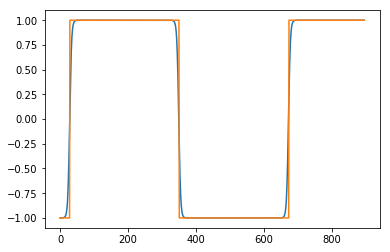

In [207]:
predicted = sign_model.predict(x_train, batch_size=128)
plt.plot(predicted)
plt.plot(y_train)

Close enough.

# Given two numbers at once, subtract second from the first:

Prepare data:

In [208]:
x_train = windowed[:896]
y_train = x_vals['diff'][:896]

x_val = windowed[897:]
y_val = x_vals['diff'][897:]

print("x:\n", x_train[:5],
      "\ny:\n", y_train[:5])

x:
 [[0.95892427 0.96164603]
 [0.96164603 0.96427626]
 [0.96427626 0.9668147 ]
 [0.9668147  0.96926113]
 [0.96926113 0.9716153 ]] 
y:
 0   -0.002722
1   -0.002630
2   -0.002538
3   -0.002446
4   -0.002354
Name: diff, dtype: float64


Prepare candidate model (single perceptron with linear activation):

In [254]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False,clipvalue=0.5)

subtract_model = Sequential()
subtract_model.add(Dense(1, input_dim=2, activation="linear"))
subtract_model.compile(loss = "mean_absolute_error", 
              optimizer = opt)
subtract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Train model:

In [255]:
subtract_model.fit(x_train, 
              y_train, 
              batch_size = 128,
              epochs = 5000,
              #validation_split = 0,
              shuffle=True,
              verbose=1,
              validation_data=(x_val,y_val))

Train on 896 samples, validate on 128 samples
Epoch 1/5000
896/896 [==============================] - 1s 924us/step - loss: 0.4157 - val_loss: 0.5660
Epoch 2/5000
896/896 [==============================] - 0s 17us/step - loss: 0.3266 - val_loss: 0.4972
Epoch 3/5000
896/896 [==============================] - 0s 17us/step - loss: 0.2395 - val_loss: 0.3855
Epoch 4/5000
896/896 [==============================] - 0s 17us/step - loss: 0.1579 - val_loss: 0.2396
Epoch 5/5000
896/896 [==============================] - 0s 18us/step - loss: 0.0731 - val_loss: 0.0515
Epoch 6/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0184 - val_loss: 0.0746
Epoch 7/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0284 - val_loss: 0.0255
Epoch 8/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0093 - val_loss: 0.0255
Epoch 9/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0073 - val_loss: 0.0185
Epoch 10/5000
896/896 [===

896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 9.1461e-04
Epoch 79/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 9.1863e-04
Epoch 80/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 7.5897e-04
Epoch 81/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 7.8878e-04
Epoch 82/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 83/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 84/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 85/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 86/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 8.3237e-04
Epoch 87/5000
896/896 [==============================] - 0s 0

Epoch 155/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 4.7532e-04
Epoch 156/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 5.9641e-04
Epoch 157/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 9.9002e-04
Epoch 158/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 159/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0010
Epoch 160/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 161/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 8.6824e-04
Epoch 162/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 7.4653e-04
Epoch 163/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 6.9148e-04
Epoch 164/5000
896/896 [============

Epoch 232/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 8.2981e-04
Epoch 233/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 234/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 235/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 6.6397e-04
Epoch 236/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 237/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 238/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 239/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 5.1727e-04
Epoch 240/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 4.3197e-04
Epoch 241/5000
896/896 [===================

Epoch 308/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 309/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 5.1997e-04
Epoch 310/5000
896/896 [==============================] - 0s 0us/step - loss: 9.3858e-04 - val_loss: 5.5765e-04
Epoch 311/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 8.3997e-04
Epoch 312/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 4.3411e-04
Epoch 313/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5616e-04 - val_loss: 8.3179e-04
Epoch 314/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 315/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 5.5760e-04
Epoch 316/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 4.1962e-04
Epoch 317/5000
896/896 

896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 2.3602e-04
Epoch 384/5000
896/896 [==============================] - 0s 17us/step - loss: 9.4097e-04 - val_loss: 0.0015
Epoch 385/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 8.0150e-04
Epoch 386/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 7.3804e-04
Epoch 387/5000
896/896 [==============================] - 0s 17us/step - loss: 8.7444e-04 - val_loss: 3.5679e-04
Epoch 388/5000
896/896 [==============================] - 0s 0us/step - loss: 7.3770e-04 - val_loss: 2.7944e-04
Epoch 389/5000
896/896 [==============================] - 0s 17us/step - loss: 7.7712e-04 - val_loss: 0.0010
Epoch 390/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 6.5674e-04
Epoch 391/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 8.1994e-04
Epoch 392/5000
896/896 [=====

Epoch 459/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 1.7200e-04
Epoch 460/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 2.0987e-04
Epoch 461/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 5.6090e-04
Epoch 462/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0022 - val_loss: 7.1623e-04
Epoch 463/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 464/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 5.0532e-04
Epoch 465/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 7.8836e-04
Epoch 466/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 467/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 468/5000
896/896 [===========

896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 5.5905e-04
Epoch 535/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 536/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 3.2580e-04
Epoch 537/5000
896/896 [==============================] - 0s 17us/step - loss: 8.6799e-04 - val_loss: 6.5849e-04
Epoch 538/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 539/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 7.9093e-04
Epoch 540/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 5.4574e-04
Epoch 541/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 542/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 5.8435e-04
Epoch 543/5000
896/896 [=====================

896/896 [==============================] - 0s 17us/step - loss: 8.6476e-04 - val_loss: 3.4859e-04
Epoch 611/5000
896/896 [==============================] - 0s 0us/step - loss: 8.2711e-04 - val_loss: 3.2994e-04
Epoch 612/5000
896/896 [==============================] - 0s 17us/step - loss: 8.0662e-04 - val_loss: 0.0011
Epoch 613/5000
896/896 [==============================] - 0s 0us/step - loss: 7.4452e-04 - val_loss: 4.1993e-04
Epoch 614/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 9.9851e-04
Epoch 615/5000
896/896 [==============================] - 0s 17us/step - loss: 9.4611e-04 - val_loss: 0.0022
Epoch 616/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 617/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 618/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 619/5000
896/896 [==============

896/896 [==============================] - 0s 0us/step - loss: 9.7755e-04 - val_loss: 4.4114e-04
Epoch 687/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 688/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 5.2078e-04
Epoch 689/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 2.5900e-04
Epoch 690/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 691/5000
896/896 [==============================] - 0s 0us/step - loss: 9.0262e-04 - val_loss: 0.0017
Epoch 692/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 693/5000
896/896 [==============================] - 0s 0us/step - loss: 8.5813e-04 - val_loss: 5.8258e-04
Epoch 694/5000
896/896 [==============================] - 0s 17us/step - loss: 8.3117e-04 - val_loss: 7.1736e-04
Epoch 695/5000
896/896 [==============

Epoch 761/5000
896/896 [==============================] - 0s 0us/step - loss: 5.6085e-04 - val_loss: 4.7338e-04
Epoch 762/5000
896/896 [==============================] - 0s 17us/step - loss: 7.8577e-04 - val_loss: 0.0011
Epoch 763/5000
896/896 [==============================] - 0s 17us/step - loss: 7.1301e-04 - val_loss: 2.2959e-04
Epoch 764/5000
896/896 [==============================] - 0s 17us/step - loss: 5.2001e-04 - val_loss: 5.1643e-04
Epoch 765/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0025
Epoch 766/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 3.9486e-04
Epoch 767/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 768/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 769/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0028 - val_loss: 0.0034
Epoch 770/5000
896/896 [

896/896 [==============================] - 0s 0us/step - loss: 7.3330e-04 - val_loss: 3.8710e-04
Epoch 837/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 838/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 839/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 3.1985e-04
Epoch 840/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 5.0286e-04
Epoch 841/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 4.5715e-04
Epoch 842/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 843/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 0.0040
Epoch 844/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 845/5000
896/896 [==============================

896/896 [==============================] - 0s 0us/step - loss: 6.0803e-04 - val_loss: 0.0013
Epoch 914/5000
896/896 [==============================] - 0s 17us/step - loss: 7.5567e-04 - val_loss: 5.3877e-04
Epoch 915/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 7.1634e-04
Epoch 916/5000
896/896 [==============================] - 0s 17us/step - loss: 6.8170e-04 - val_loss: 0.0012
Epoch 917/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 9.5560e-05
Epoch 918/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 919/5000
896/896 [==============================] - 0s 17us/step - loss: 9.8094e-04 - val_loss: 6.3610e-05
Epoch 920/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 7.9932e-04
Epoch 921/5000
896/896 [==============================] - 0s 0us/step - loss: 9.9525e-04 - val_loss: 8.5902e-04
Epoch 922/5000
896/896 [======

Epoch 989/5000
896/896 [==============================] - 0s 0us/step - loss: 8.8100e-04 - val_loss: 2.3309e-04
Epoch 990/5000
896/896 [==============================] - 0s 17us/step - loss: 8.1935e-04 - val_loss: 2.2944e-04
Epoch 991/5000
896/896 [==============================] - 0s 0us/step - loss: 6.2533e-04 - val_loss: 0.0019
Epoch 992/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 993/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 5.1831e-04
Epoch 994/5000
896/896 [==============================] - 0s 0us/step - loss: 9.7616e-04 - val_loss: 0.0014
Epoch 995/5000
896/896 [==============================] - 0s 0us/step - loss: 9.5654e-04 - val_loss: 4.3339e-04
Epoch 996/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 9.7126e-04
Epoch 997/5000
896/896 [==============================] - 0s 0us/step - loss: 9.8358e-04 - val_loss: 2.8280e-04
Epoch 998/500

Epoch 1064/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 1065/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 1066/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 1067/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 1068/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 1069/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0028
Epoch 1070/5000
896/896 [==============================] - 0s 18us/step - loss: 0.0013 - val_loss: 2.4313e-04
Epoch 1071/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0023 - val_loss: 7.1217e-04
Epoch 1072/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1073/5000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 3.2880e-04
Epoch 1140/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 3.9761e-04
Epoch 1141/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 1142/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 7.8506e-04
Epoch 1143/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 1144/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 1.1296e-04
Epoch 1145/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 1146/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 7.8077e-04
Epoch 1147/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 4.6883e-04
Epoch 1148/5000
896/896 [=============

896/896 [==============================] - 0s 35us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1215/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 1216/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 1217/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1218/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1219/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0028 - val_loss: 3.1968e-04
Epoch 1220/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 1221/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 1222/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 5.1419e-04
Epoch 1223/5000
896/896 [=============================

896/896 [==============================] - 0s 17us/step - loss: 4.6659e-04 - val_loss: 7.9882e-04
Epoch 1290/5000
896/896 [==============================] - 0s 17us/step - loss: 7.5958e-04 - val_loss: 0.0011
Epoch 1291/5000
896/896 [==============================] - 0s 17us/step - loss: 6.6501e-04 - val_loss: 0.0014
Epoch 1292/5000
896/896 [==============================] - 0s 17us/step - loss: 9.0130e-04 - val_loss: 1.7757e-04
Epoch 1293/5000
896/896 [==============================] - 0s 17us/step - loss: 8.8181e-04 - val_loss: 5.6376e-04
Epoch 1294/5000
896/896 [==============================] - 0s 0us/step - loss: 8.5139e-04 - val_loss: 5.2003e-04
Epoch 1295/5000
896/896 [==============================] - 0s 17us/step - loss: 9.3007e-04 - val_loss: 2.9070e-04
Epoch 1296/5000
896/896 [==============================] - 0s 17us/step - loss: 9.4022e-04 - val_loss: 3.2300e-04
Epoch 1297/5000
896/896 [==============================] - 0s 0us/step - loss: 8.9556e-04 - val_loss: 6.7816e-04


Epoch 1364/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 1365/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1366/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0012 - val_loss: 5.0054e-04
Epoch 1367/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 3.3514e-04
Epoch 1368/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1369/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 5.9696e-04
Epoch 1370/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 1.3402e-04
Epoch 1371/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 2.8802e-04
Epoch 1372/5000
896/896 [==============================] - 0s 17us/step - loss: 7.3112e-04 - val_loss: 8.5004e-04
Epoch 1373/5000
89

Epoch 1439/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 7.2854e-04
Epoch 1440/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 1.6362e-04
Epoch 1441/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 1442/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 1443/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 1444/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 1445/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1446/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 3.6449e-04
Epoch 1447/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 1448/5000
896/896 [===========

Epoch 1514/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 8.7693e-04
Epoch 1515/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1516/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 4.3350e-04
Epoch 1517/5000
896/896 [==============================] - 0s 17us/step - loss: 8.3298e-04 - val_loss: 6.4614e-04
Epoch 1518/5000
896/896 [==============================] - 0s 17us/step - loss: 9.2318e-04 - val_loss: 8.7767e-04
Epoch 1519/5000
896/896 [==============================] - 0s 0us/step - loss: 8.9470e-04 - val_loss: 5.6896e-04
Epoch 1520/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 1521/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 1522/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 1523/5000

Epoch 1589/5000
896/896 [==============================] - 0s 17us/step - loss: 9.5248e-04 - val_loss: 3.8741e-04
Epoch 1590/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 1591/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 7.2500e-04
Epoch 1592/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 3.9885e-04
Epoch 1593/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1594/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 1595/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 1596/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0023 - val_loss: 0.0044
Epoch 1597/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 1598/5000
896/896 [=======

896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 1665/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1666/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0028 - val_loss: 9.8609e-04
Epoch 1667/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 1668/5000
896/896 [==============================] - 0s 0us/step - loss: 9.6993e-04 - val_loss: 2.9298e-04
Epoch 1669/5000
896/896 [==============================] - 0s 17us/step - loss: 7.6457e-04 - val_loss: 4.2541e-04
Epoch 1670/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1671/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 5.4745e-04
Epoch 1672/5000
896/896 [==============================] - 0s 17us/step - loss: 6.6229e-04 - val_loss: 3.5842e-04
Epoch 1673/5000
896/896 [=========

896/896 [==============================] - 0s 0us/step - loss: 7.7314e-04 - val_loss: 0.0013
Epoch 1740/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 2.5364e-04
Epoch 1741/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 1742/5000
896/896 [==============================] - 0s 0us/step - loss: 7.4068e-04 - val_loss: 3.8454e-04
Epoch 1743/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 1744/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 1745/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 7.7119e-05
Epoch 1746/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 1747/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1748/5000
896/896 [=====================

896/896 [==============================] - 0s 35us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 1815/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0033
Epoch 1816/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1817/5000
896/896 [==============================] - 0s 0us/step - loss: 8.3788e-04 - val_loss: 0.0021
Epoch 1818/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 1819/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0030
Epoch 1820/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1821/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 1822/5000
896/896 [==============================] - 0s 17us/step - loss: 7.7906e-04 - val_loss: 2.9295e-04
Epoch 1823/5000
896/896 [===========================

896/896 [==============================] - 0s 35us/step - loss: 0.0021 - val_loss: 2.4830e-04
Epoch 1890/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 3.2472e-04
Epoch 1891/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1892/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 1893/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 3.8138e-04
Epoch 1894/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 2.1626e-04
Epoch 1895/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 1896/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 2.0638e-04
Epoch 1897/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 1898/5000
896/896 [=================

896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 4.7973e-04
Epoch 1965/5000
896/896 [==============================] - 0s 17us/step - loss: 7.4416e-04 - val_loss: 0.0015
Epoch 1966/5000
896/896 [==============================] - 0s 17us/step - loss: 9.3443e-04 - val_loss: 3.1961e-04
Epoch 1967/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 3.9531e-04
Epoch 1968/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1969/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 4.0233e-04
Epoch 1970/5000
896/896 [==============================] - 0s 17us/step - loss: 7.6553e-04 - val_loss: 0.0018
Epoch 1971/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0027
Epoch 1972/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 6.5823e-04
Epoch 1973/5000
896/896 [=====

896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2040/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 4.6005e-04
Epoch 2041/5000
896/896 [==============================] - 0s 17us/step - loss: 5.7676e-04 - val_loss: 7.7537e-04
Epoch 2042/5000
896/896 [==============================] - 0s 0us/step - loss: 7.1533e-04 - val_loss: 9.1267e-04
Epoch 2043/5000
896/896 [==============================] - 0s 17us/step - loss: 9.0462e-04 - val_loss: 3.4514e-04
Epoch 2044/5000
896/896 [==============================] - 0s 17us/step - loss: 7.4350e-04 - val_loss: 1.6048e-04
Epoch 2045/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 4.4921e-04
Epoch 2046/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 4.8883e-04
Epoch 2047/5000
896/896 [==============================] - 0s 0us/step - loss: 7.1364e-04 - val_loss: 4.3103e-04
Epoch 2048/500

896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 2115/5000
896/896 [==============================] - 0s 17us/step - loss: 9.2755e-04 - val_loss: 2.8392e-04
Epoch 2116/5000
896/896 [==============================] - 0s 17us/step - loss: 9.5218e-04 - val_loss: 1.8291e-04
Epoch 2117/5000
896/896 [==============================] - 0s 17us/step - loss: 6.9008e-04 - val_loss: 8.5829e-04
Epoch 2118/5000
896/896 [==============================] - 0s 17us/step - loss: 6.5540e-04 - val_loss: 5.3563e-04
Epoch 2119/5000
896/896 [==============================] - 0s 17us/step - loss: 7.3402e-04 - val_loss: 8.4199e-05
Epoch 2120/5000
896/896 [==============================] - 0s 17us/step - loss: 7.5469e-04 - val_loss: 2.3367e-04
Epoch 2121/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 4.0271e-04
Epoch 2122/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 2123

896/896 [==============================] - 0s 17us/step - loss: 5.8155e-04 - val_loss: 0.0010
Epoch 2190/5000
896/896 [==============================] - 0s 17us/step - loss: 9.1595e-04 - val_loss: 9.2482e-04
Epoch 2191/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2192/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0027
Epoch 2193/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 2194/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 2195/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 0.0030
Epoch 2196/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 2197/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 7.7766e-04
Epoch 2198/5000
896/896 [========================

896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 2265/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0033
Epoch 2266/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2267/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5591e-04 - val_loss: 0.0015
Epoch 2268/5000
896/896 [==============================] - 0s 35us/step - loss: 9.6922e-04 - val_loss: 0.0016
Epoch 2269/5000
896/896 [==============================] - 0s 17us/step - loss: 9.7346e-04 - val_loss: 2.2425e-04
Epoch 2270/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 2.9639e-04
Epoch 2271/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0012 - val_loss: 2.6892e-04
Epoch 2272/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2273/5000
896/896 [==============

Epoch 2339/5000
896/896 [==============================] - 0s 17us/step - loss: 7.1749e-04 - val_loss: 5.0832e-04
Epoch 2340/5000
896/896 [==============================] - 0s 17us/step - loss: 8.3474e-04 - val_loss: 5.3063e-04
Epoch 2341/5000
896/896 [==============================] - 0s 0us/step - loss: 6.4552e-04 - val_loss: 6.0394e-05
Epoch 2342/5000
896/896 [==============================] - 0s 17us/step - loss: 8.7415e-04 - val_loss: 1.8165e-04
Epoch 2343/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2344/5000
896/896 [==============================] - 0s 17us/step - loss: 9.6695e-04 - val_loss: 0.0037
Epoch 2345/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 8.7846e-04
Epoch 2346/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 1.4725e-04
Epoch 2347/5000
896/896 [==============================] - 0s 17us/step - loss: 3.6796e-04 - val_loss: 9.1823

Epoch 2414/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 2415/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0021 - val_loss: 0.0028
Epoch 2416/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 2417/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 2418/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2419/5000
896/896 [==============================] - ETA: 0s - loss: 0.002 - 0s 17us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2420/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 7.7951e-04
Epoch 2421/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2422/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2423/5000
896

896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 2490/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 2491/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 2492/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 2493/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2494/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 2495/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 2496/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 7.7103e-04
Epoch 2497/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0024 - val_loss: 9.1886e-04
Epoch 2498/5000
896/896 [==============================] -

Epoch 2564/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2565/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 3.1301e-04
Epoch 2566/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0019 - val_loss: 4.3901e-04
Epoch 2567/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0020 - val_loss: 9.6963e-05
Epoch 2568/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 2.9026e-04
Epoch 2569/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 5.4492e-04
Epoch 2570/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 2571/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 2572/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 2573/5000
896/896 [======

896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 2640/5000
896/896 [==============================] - 0s 17us/step - loss: 7.5488e-04 - val_loss: 0.0021
Epoch 2641/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 3.6727e-04
Epoch 2642/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 2643/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 2644/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 2645/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 3.6562e-04
Epoch 2646/5000
896/896 [==============================] - 0s 17us/step - loss: 9.3268e-04 - val_loss: 0.0018
Epoch 2647/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2648/5000
896/896 [==========================

Epoch 2715/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 7.9789e-04
Epoch 2716/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 3.3757e-04
Epoch 2717/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 4.1648e-04
Epoch 2718/5000
896/896 [==============================] - 0s 17us/step - loss: 8.3779e-04 - val_loss: 0.0016
Epoch 2719/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2720/5000
896/896 [==============================] - 0s 0us/step - loss: 8.2863e-04 - val_loss: 1.9514e-04
Epoch 2721/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 9.9268e-04
Epoch 2722/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 4.9367e-04
Epoch 2723/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2724/5000
89

896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2791/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2792/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 2.6899e-04
Epoch 2793/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 7.9041e-05
Epoch 2794/5000
896/896 [==============================] - 0s 0us/step - loss: 8.0861e-04 - val_loss: 3.9614e-04
Epoch 2795/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0023 - val_loss: 2.5433e-04
Epoch 2796/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0023 - val_loss: 5.8958e-04
Epoch 2797/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 2.3495e-04
Epoch 2798/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 6.4982e-04
Epoch 2799/5000
896/896 [========

896/896 [==============================] - 0s 35us/step - loss: 0.0016 - val_loss: 7.9459e-04
Epoch 2866/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 2867/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 3.3960e-04
Epoch 2868/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 2869/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 6.9751e-04
Epoch 2870/5000
896/896 [==============================] - 0s 35us/step - loss: 5.5599e-04 - val_loss: 0.0027
Epoch 2871/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 3.0654e-04
Epoch 2872/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0016 - val_loss: 9.2153e-04
Epoch 2873/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 9.0288e-04
Epoch 2874/5000
896/896 [==========

896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 2.1144e-04
Epoch 2941/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 2942/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 2.5162e-04
Epoch 2943/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 1.4054e-04
Epoch 2944/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0019 - val_loss: 5.6462e-04
Epoch 2945/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 2946/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 2947/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 5.9846e-04
Epoch 2948/5000
896/896 [==============================] - 0s 35us/step - loss: 8.7216e-04 - val_loss: 0.0018
Epoch 2949/5000
896/896 [===============

896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 4.3577e-04
Epoch 3016/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 1.7034e-04
Epoch 3017/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3018/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3019/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 3020/5000
896/896 [==============================] - 0s 17us/step - loss: 8.0580e-04 - val_loss: 5.8959e-04
Epoch 3021/5000
896/896 [==============================] - 0s 17us/step - loss: 7.0034e-04 - val_loss: 3.8746e-04
Epoch 3022/5000
896/896 [==============================] - 0s 17us/step - loss: 6.8921e-04 - val_loss: 8.6872e-05
Epoch 3023/5000
896/896 [==============================] - 0s 0us/step - loss: 8.2085e-04 - val_loss: 8.8192e-04
Epoch 3024/5000
896/896

896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3090/5000
896/896 [==============================] - 0s 17us/step - loss: 6.0624e-04 - val_loss: 0.0012
Epoch 3091/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3092/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 6.8844e-04
Epoch 3093/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3094/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3095/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 6.1826e-04
Epoch 3096/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 6.4085e-04
Epoch 3097/5000
896/896 [==============================] - 0s 17us/step - loss: 7.9746e-04 - val_loss: 5.3133e-04
Epoch 3098/5000
896/896 [================

896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3165/5000
896/896 [==============================] - 0s 17us/step - loss: 8.6188e-04 - val_loss: 7.4545e-04
Epoch 3166/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0032
Epoch 3167/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3168/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 3169/5000
896/896 [==============================] - 0s 0us/step - loss: 9.3408e-04 - val_loss: 0.0018
Epoch 3170/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 0.0035
Epoch 3171/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 4.3465e-04
Epoch 3172/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 7.0057e-04
Epoch 3173/5000
896/896 [==================

896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 3.2934e-04
Epoch 3240/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 2.0619e-04
Epoch 3241/5000
896/896 [==============================] - 0s 0us/step - loss: 8.9360e-04 - val_loss: 1.3705e-04
Epoch 3242/5000
896/896 [==============================] - 0s 17us/step - loss: 5.8896e-04 - val_loss: 0.0011
Epoch 3243/5000
896/896 [==============================] - 0s 17us/step - loss: 9.5500e-04 - val_loss: 0.0036
Epoch 3244/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 5.0093e-04
Epoch 3245/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 3246/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 8.3115e-04
Epoch 3247/5000
896/896 [==============================] - 0s 17us/step - loss: 7.6707e-04 - val_loss: 0.0011
Epoch 3248/5000
896/896 [==

Epoch 3314/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3315/5000
896/896 [==============================] - 0s 17us/step - loss: 9.9120e-04 - val_loss: 5.1552e-04
Epoch 3316/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0021 - val_loss: 5.4383e-04
Epoch 3317/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 3.1462e-04
Epoch 3318/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 6.0790e-04
Epoch 3319/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 2.6682e-04
Epoch 3320/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3321/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0024 - val_loss: 3.2007e-04
Epoch 3322/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3323/5000
89

896/896 [==============================] - 0s 35us/step - loss: 9.2570e-04 - val_loss: 0.0014
Epoch 3390/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 2.2930e-04
Epoch 3391/5000
896/896 [==============================] - 0s 17us/step - loss: 6.4077e-04 - val_loss: 0.0026
Epoch 3392/5000
896/896 [==============================] - 0s 17us/step - loss: 8.4820e-04 - val_loss: 6.8789e-04
Epoch 3393/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3394/5000
896/896 [==============================] - 0s 17us/step - loss: 5.3056e-04 - val_loss: 4.0379e-04
Epoch 3395/5000
896/896 [==============================] - 0s 17us/step - loss: 3.7549e-04 - val_loss: 8.8395e-04
Epoch 3396/5000
896/896 [==============================] - 0s 0us/step - loss: 5.3770e-04 - val_loss: 3.5164e-04
Epoch 3397/5000
896/896 [==============================] - 0s 0us/step - loss: 8.1637e-04 - val_loss: 3.6132e-04
Epoch 3398/5

Epoch 3464/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 6.1338e-04
Epoch 3465/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 8.3479e-04
Epoch 3466/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 7.6086e-04
Epoch 3467/5000
896/896 [==============================] - 0s 17us/step - loss: 7.8763e-04 - val_loss: 0.0011
Epoch 3468/5000
896/896 [==============================] - 0s 17us/step - loss: 5.6144e-04 - val_loss: 5.2932e-04
Epoch 3469/5000
896/896 [==============================] - 0s 17us/step - loss: 6.5843e-04 - val_loss: 0.0016
Epoch 3470/5000
896/896 [==============================] - 0s 17us/step - loss: 5.4985e-04 - val_loss: 2.4853e-04
Epoch 3471/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 8.8981e-04
Epoch 3472/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 1.0653e-04
Epo

Epoch 3538/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 7.7985e-04
Epoch 3539/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 3.3892e-04
Epoch 3540/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 6.6394e-04
Epoch 3541/5000
896/896 [==============================] - ETA: 0s - loss: 0.001 - 0s 17us/step - loss: 0.0016 - val_loss: 6.0385e-04
Epoch 3542/5000
896/896 [==============================] - 0s 17us/step - loss: 9.6867e-04 - val_loss: 4.5044e-04
Epoch 3543/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3544/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 2.1670e-04
Epoch 3545/5000
896/896 [==============================] - 0s 17us/step - loss: 7.8854e-04 - val_loss: 0.0021
Epoch 3546/5000
896/896 [==============================] - 0s 17us/step - loss: 8.6800e-04 - val

896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 1.2294e-04
Epoch 3614/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 2.8580e-04
Epoch 3615/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 3616/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3617/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 1.5591e-04
Epoch 3618/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3619/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3620/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 6.2985e-04
Epoch 3621/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0032
Epoch 3622/5000
896/896 [=====================

896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 8.0770e-04
Epoch 3689/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 6.4098e-04
Epoch 3690/5000
896/896 [==============================] - 0s 17us/step - loss: 8.3926e-04 - val_loss: 0.0013
Epoch 3691/5000
896/896 [==============================] - 0s 17us/step - loss: 6.5123e-04 - val_loss: 2.0506e-04
Epoch 3692/5000
896/896 [==============================] - 0s 17us/step - loss: 7.9255e-04 - val_loss: 2.4043e-04
Epoch 3693/5000
896/896 [==============================] - 0s 0us/step - loss: 5.2869e-04 - val_loss: 0.0014
Epoch 3694/5000
896/896 [==============================] - 0s 0us/step - loss: 8.5568e-04 - val_loss: 8.0055e-04
Epoch 3695/5000
896/896 [==============================] - 0s 17us/step - loss: 6.7978e-04 - val_loss: 0.0010
Epoch 3696/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3697/5000
896/

896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3763/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 5.4704e-05
Epoch 3764/5000
896/896 [==============================] - 0s 17us/step - loss: 7.8765e-04 - val_loss: 0.0018
Epoch 3765/5000
896/896 [==============================] - 0s 17us/step - loss: 9.5489e-04 - val_loss: 9.9692e-04
Epoch 3766/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5554e-04 - val_loss: 7.2458e-04
Epoch 3767/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 8.6431e-04
Epoch 3768/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 5.3384e-04
Epoch 3769/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 0.0023
Epoch 3770/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0012 - val_loss: 0.0034
Epoch 3771/5000
896/896 [=========

Epoch 3837/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 7.7412e-04
Epoch 3838/5000
896/896 [==============================] - 0s 0us/step - loss: 9.4312e-04 - val_loss: 7.9266e-04
Epoch 3839/5000
896/896 [==============================] - 0s 17us/step - loss: 8.7949e-04 - val_loss: 0.0016
Epoch 3840/5000
896/896 [==============================] - 0s 17us/step - loss: 9.8816e-04 - val_loss: 4.8497e-04
Epoch 3841/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 4.5620e-04
Epoch 3842/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 1.1269e-04
Epoch 3843/5000
896/896 [==============================] - 0s 17us/step - loss: 8.9143e-04 - val_loss: 8.8207e-04
Epoch 3844/5000
896/896 [==============================] - 0s 0us/step - loss: 9.5072e-04 - val_loss: 0.0014
Epoch 3845/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 5.2765e-05
E

896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 6.3595e-04
Epoch 3913/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 4.4903e-04
Epoch 3914/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 3915/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3916/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0013 - val_loss: 3.0730e-04
Epoch 3917/5000
896/896 [==============================] - 0s 17us/step - loss: 9.7194e-04 - val_loss: 5.4249e-04
Epoch 3918/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3919/5000
896/896 [==============================] - 0s 17us/step - loss: 6.9868e-04 - val_loss: 0.0015
Epoch 3920/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5425e-04 - val_loss: 2.1373e-04
Epoch 3921/5000
896/896 [=====

896/896 [==============================] - 0s 0us/step - loss: 8.7231e-04 - val_loss: 4.6146e-05
Epoch 3988/5000
896/896 [==============================] - 0s 17us/step - loss: 5.6890e-04 - val_loss: 2.7265e-04
Epoch 3989/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 3990/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3991/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 2.1236e-04
Epoch 3992/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 3993/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 3994/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 3995/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 3996/5000
896/896 [=====================

896/896 [==============================] - 0s 17us/step - loss: 0.0028 - val_loss: 4.6790e-04
Epoch 4063/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4064/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0010 - val_loss: 8.3579e-04
Epoch 4065/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4066/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4067/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 5.1913e-04
Epoch 4068/5000
896/896 [==============================] - 0s 17us/step - loss: 7.0970e-04 - val_loss: 9.5472e-04
Epoch 4069/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 2.8823e-04
Epoch 4070/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 2.9371e-04
Epoch 4071/5000
896/896 [=========

896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 1.9433e-04
Epoch 4137/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 4.4236e-05
Epoch 4138/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 2.0643e-04
Epoch 4139/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 3.3870e-04
Epoch 4140/5000
896/896 [==============================] - 0s 17us/step - loss: 5.9864e-04 - val_loss: 0.0018
Epoch 4141/5000
896/896 [==============================] - 0s 0us/step - loss: 9.2220e-04 - val_loss: 0.0019
Epoch 4142/5000
896/896 [==============================] - 0s 17us/step - loss: 9.0516e-04 - val_loss: 0.0019
Epoch 4143/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 4.7246e-04
Epoch 4144/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 7.8234e-04
Epoch 4145/5000
896/896 [===

896/896 [==============================] - 0s 17us/step - loss: 0.0020 - val_loss: 2.2435e-04
Epoch 4212/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 2.8145e-04
Epoch 4213/5000
896/896 [==============================] - 0s 0us/step - loss: 8.2516e-04 - val_loss: 6.2946e-04
Epoch 4214/5000
896/896 [==============================] - 0s 17us/step - loss: 7.2186e-04 - val_loss: 2.7204e-04
Epoch 4215/5000
896/896 [==============================] - 0s 17us/step - loss: 6.6490e-04 - val_loss: 5.2077e-04
Epoch 4216/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5618e-04 - val_loss: 8.9986e-04
Epoch 4217/5000
896/896 [==============================] - 0s 0us/step - loss: 7.5094e-04 - val_loss: 9.2061e-04
Epoch 4218/5000
896/896 [==============================] - 0s 17us/step - loss: 7.3202e-04 - val_loss: 0.0020
Epoch 4219/5000
896/896 [==============================] - 0s 17us/step - loss: 7.9055e-04 - val_loss: 0.0014
Epoch 42

896/896 [==============================] - 0s 17us/step - loss: 7.5477e-04 - val_loss: 8.0982e-04
Epoch 4286/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4287/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 3.2700e-04
Epoch 4288/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 4289/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4290/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 1.4169e-04
Epoch 4291/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 4.6862e-04
Epoch 4292/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0019 - val_loss: 4.2844e-04
Epoch 4293/5000
896/896 [==============================] - 0s 17us/step - loss: 6.9724e-04 - val_loss: 4.4766e-04
Epoch 4294/5000
896/896 [========

Epoch 4360/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4361/5000
896/896 [==============================] - 0s 17us/step - loss: 6.7732e-04 - val_loss: 0.0014
Epoch 4362/5000
896/896 [==============================] - 0s 17us/step - loss: 5.9912e-04 - val_loss: 0.0019
Epoch 4363/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0011 - val_loss: 7.4463e-05
Epoch 4364/5000
896/896 [==============================] - 0s 17us/step - loss: 7.7100e-04 - val_loss: 0.0028
Epoch 4365/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 0.0034
Epoch 4366/5000
896/896 [==============================] - 0s 17us/step - loss: 8.5419e-04 - val_loss: 6.3661e-04
Epoch 4367/5000
896/896 [==============================] - 0s 0us/step - loss: 7.1287e-04 - val_loss: 5.0054e-04
Epoch 4368/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0015 - val_loss: 5.7870e-04
Epoch 4369/50

Epoch 4435/5000
896/896 [==============================] - 0s 17us/step - loss: 4.5262e-04 - val_loss: 5.3379e-04
Epoch 4436/5000
896/896 [==============================] - 0s 0us/step - loss: 6.8369e-04 - val_loss: 0.0010
Epoch 4437/5000
896/896 [==============================] - 0s 17us/step - loss: 9.0005e-04 - val_loss: 0.0017
Epoch 4438/5000
896/896 [==============================] - 0s 17us/step - loss: 7.4614e-04 - val_loss: 0.0010
Epoch 4439/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 4.2212e-04
Epoch 4440/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 3.3388e-04
Epoch 4441/5000
896/896 [==============================] - 0s 17us/step - loss: 8.0809e-04 - val_loss: 0.0014
Epoch 4442/5000
896/896 [==============================] - 0s 17us/step - loss: 9.9381e-04 - val_loss: 0.0018
Epoch 4443/5000
896/896 [==============================] - 0s 17us/step - loss: 6.9109e-04 - val_loss: 0.0017
Epoch 44

896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4510/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 9.6744e-04
Epoch 4511/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 4.0283e-04
Epoch 4512/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4513/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 9.5221e-04
Epoch 4514/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 2.8915e-04
Epoch 4515/5000
896/896 [==============================] - 0s 17us/step - loss: 8.4098e-04 - val_loss: 6.6770e-04
Epoch 4516/5000
896/896 [==============================] - 0s 0us/step - loss: 7.1128e-04 - val_loss: 0.0015
Epoch 4517/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 4518/5000
896/896 [===========

896/896 [==============================] - 0s 0us/step - loss: 0.0018 - val_loss: 2.5785e-04
Epoch 4585/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 6.8828e-04
Epoch 4586/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4587/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4588/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4589/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 1.6548e-04
Epoch 4590/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4591/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4592/5000
896/896 [==============================] - 0s 17us/step - loss: 6.8510e-04 - val_loss: 1.4452e-04
Epoch 4593/5000
896/896 [====================

896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 4.8836e-04
Epoch 4660/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 3.9022e-04
Epoch 4661/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0024 - val_loss: 3.0182e-04
Epoch 4662/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 2.4186e-04
Epoch 4663/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 2.8908e-04
Epoch 4664/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0016 - val_loss: 1.9156e-04
Epoch 4665/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0018 - val_loss: 6.2301e-05
Epoch 4666/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0017 - val_loss: 1.9828e-04
Epoch 4667/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 2.4672e-04
Epoch 4668/5000
896/896 [=

896/896 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4734/5000
896/896 [==============================] - 0s 17us/step - loss: 9.6875e-04 - val_loss: 6.1578e-04
Epoch 4735/5000
896/896 [==============================] - 0s 17us/step - loss: 7.5637e-04 - val_loss: 0.0015
Epoch 4736/5000
896/896 [==============================] - 0s 17us/step - loss: 6.3411e-04 - val_loss: 9.6931e-04
Epoch 4737/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4738/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 4739/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4740/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4741/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4742/5000
896/896 [===================

896/896 [==============================] - 0s 17us/step - loss: 0.0014 - val_loss: 3.9160e-04
Epoch 4808/5000
896/896 [==============================] - 0s 35us/step - loss: 6.4072e-04 - val_loss: 6.0498e-04
Epoch 4809/5000
896/896 [==============================] - 0s 17us/step - loss: 4.6885e-04 - val_loss: 5.7812e-04
Epoch 4810/5000
896/896 [==============================] - 0s 17us/step - loss: 7.3039e-04 - val_loss: 0.0023
Epoch 4811/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4812/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 8.8768e-04
Epoch 4813/5000
896/896 [==============================] - 0s 35us/step - loss: 0.0011 - val_loss: 5.8511e-04
Epoch 4814/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0015 - val_loss: 9.1438e-04
Epoch 4815/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4816/5000
896/896 [=

Epoch 4882/5000
896/896 [==============================] - 0s 17us/step - loss: 8.1394e-04 - val_loss: 5.1640e-04
Epoch 4883/5000
896/896 [==============================] - 0s 17us/step - loss: 6.6372e-04 - val_loss: 0.0011
Epoch 4884/5000
896/896 [==============================] - 0s 0us/step - loss: 7.3271e-04 - val_loss: 0.0011
Epoch 4885/5000
896/896 [==============================] - 0s 17us/step - loss: 7.9176e-04 - val_loss: 0.0038
Epoch 4886/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4887/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 4888/5000
896/896 [==============================] - 0s 0us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 4889/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 1.2458e-04
Epoch 4890/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 2.1666e-04
Epoch 4891/5000
896/8

Epoch 4957/5000
896/896 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4958/5000
896/896 [==============================] - 0s 17us/step - loss: 6.7140e-04 - val_loss: 8.3988e-04
Epoch 4959/5000
896/896 [==============================] - 0s 17us/step - loss: 6.5484e-04 - val_loss: 5.8821e-04
Epoch 4960/5000
896/896 [==============================] - 0s 0us/step - loss: 7.5822e-04 - val_loss: 3.5748e-04
Epoch 4961/5000
896/896 [==============================] - 0s 17us/step - loss: 6.1292e-04 - val_loss: 2.8672e-04
Epoch 4962/5000
896/896 [==============================] - 0s 17us/step - loss: 7.0122e-04 - val_loss: 7.3699e-04
Epoch 4963/5000
896/896 [==============================] - 0s 17us/step - loss: 5.8994e-04 - val_loss: 0.0014
Epoch 4964/5000
896/896 [==============================] - 0s 17us/step - loss: 8.1813e-04 - val_loss: 0.0011
Epoch 4965/5000
896/896 [==============================] - 0s 17us/step - loss: 6.8195e-04 - val_loss: 6.

In [256]:
subtract_model.get_weights()

[array([[ 0.997445 ],
        [-0.9963815]], dtype=float32), array([-2.1794694e-05], dtype=float32)]

Correct answer is below:

In [224]:
weights = subtract_model.get_weights()
weights[0][0] = 1
weights[0][1] = -1
weights[1][0] = 0
subtract_model.set_weights(weights)

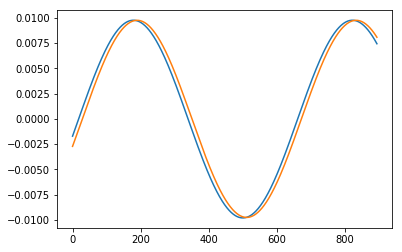

In [257]:
predicted = subtract_model.predict(x_train, batch_size=128)
plt.plot(predicted)
plt.plot(y_train)

# Time series - return current and previous values

Prepare data:

In [311]:
x_train = x_vals['shifted'][:896].values.reshape(-1,1,1)
y_train = windowed[:896]

#y_train[0][0] = 0 #fix first value - this is the initial state

x_val = x_vals['shifted'][897:].values.reshape(-1,1,1)
y_val = windowed[897:]

print("x:\n", x_train[:5],
      "\ny:\n", y_train[:5])

x:
 [[[0.96164603]]

 [[0.96427626]]

 [[0.9668147 ]]

 [[0.96926113]]

 [[0.9716153 ]]] 
y:
 [[0.         0.96164603]
 [0.96164603 0.96427626]
 [0.96427626 0.9668147 ]
 [0.9668147  0.96926113]
 [0.96926113 0.9716153 ]]


Prepare candidate model (we need cells with memory, use LSTM).
We want to solve a general case, where we do not know the time difference between relationships. We will use time_steps = 1, and no sliding window. This will hurt learning speed. We need a stateful model, to remember the cell state between training batches. Finally, batch size will be set to 1. We cannot shuffle time series, time dependencies would be lost.

In [357]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False,clipvalue=0.5)

batch_size = 1
time_steps = 1
features = 1

series_model = Sequential()
series_model.add(LSTM(2,
                      batch_input_shape=(batch_size,time_steps,features),
                      stateful=True,
                      return_sequences=False,
                      activation='linear'))
#series_model.add(Dense(16, activation='relu'))
#series_model.add(Dense(2))
series_model.compile(loss = "mean_squared_error", 
              optimizer = opt)
series_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (1, 2)                    32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [364]:
reset_states_callback = LambdaCallback(
    on_epoch_begin=series_model.reset_states())
        
series_model.fit(x_train, 
              y_train, 
              batch_size = batch_size,
              epochs = 2000,
              #validation_split = 0,
              shuffle=False,
              verbose=1,
              validation_data=(x_val,y_val),
              callbacks=[reset_states_callback])

Train on 896 samples, validate on 128 samples
Epoch 1/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 2/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 3/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 4/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 5/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 6/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 7/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 8/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 9/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 10/2000
896/896 [=============

896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 80/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 81/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 82/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 83/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 84/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 85/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 86/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 87/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 88/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0012 - v

Epoch 158/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 159/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 160/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 161/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 162/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0362
Epoch 163/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0026 - val_loss: 0.0919
Epoch 164/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.1453
Epoch 165/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.1180
Epoch 166/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.1015
Epoch 167/2000
896/896 [==============================] - 1s 2ms

Epoch 237/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.2116
Epoch 238/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.2166
Epoch 239/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.1316
Epoch 240/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.1645
Epoch 241/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.2003
Epoch 242/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.1703
Epoch 243/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.2089
Epoch 244/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.2030
Epoch 245/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.2074
Epoch 246/2000
896/896 [==============================] - 1s 2ms

Epoch 316/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.1592
Epoch 317/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0923
Epoch 318/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0092 - val_loss: 0.0956
Epoch 319/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0946
Epoch 320/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.0311 - val_loss: 0.0184
Epoch 321/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 7.3552e-04
Epoch 322/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 9.5579e-04
Epoch 323/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 324/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 325/2000
896/896 [==============================] 

896/896 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 7.4922e-04
Epoch 394/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 395/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 396/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 397/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 398/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 399/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 400/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.0207 - val_loss: 0.0075
Epoch 401/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.0078 - val_loss: 9.5448e-04
Epoch 402/2000
896/896 [==============================] - 1s 2ms/step -

896/896 [==============================] - 1s 2ms/step - loss: 0.1128 - val_loss: 0.0115
Epoch 472/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1109 - val_loss: 0.0109
Epoch 473/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1131 - val_loss: 0.0117
Epoch 474/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1160 - val_loss: 0.0127
Epoch 475/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1163 - val_loss: 0.0133
Epoch 476/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1166 - val_loss: 0.0139
Epoch 477/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1180 - val_loss: 0.0141
Epoch 478/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1218 - val_loss: 0.0147
Epoch 479/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.1188 - val_loss: 0.0156
Epoch 480/2000
896/896 [==============================] - 1s 2ms/step - loss: 0

896/896 [==============================] - 1s 2ms/step - loss: 0.3120 - val_loss: 0.0547
Epoch 550/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.0259
Epoch 551/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3159 - val_loss: 0.0115
Epoch 552/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3993 - val_loss: 0.0097
Epoch 553/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4127 - val_loss: 0.0094
Epoch 554/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6347 - val_loss: 0.0089
Epoch 555/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4028 - val_loss: 0.0087
Epoch 556/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.6083 - val_loss: 0.0083
Epoch 557/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3913 - val_loss: 0.0081
Epoch 558/2000
896/896 [==============================] - 2s 2ms/step - loss: 0

896/896 [==============================] - 1s 2ms/step - loss: 1.9616 - val_loss: 7.4555e-04
Epoch 628/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.4907 - val_loss: 7.3263e-04
Epoch 629/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.5615 - val_loss: 7.3202e-04
Epoch 630/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.9892 - val_loss: 7.5485e-04
Epoch 631/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.5743 - val_loss: 7.4475e-04
Epoch 632/2000
896/896 [==============================] - 2s 2ms/step - loss: 1.6533 - val_loss: 7.4783e-04
Epoch 633/2000
896/896 [==============================] - 1s 2ms/step - loss: 2.1196 - val_loss: 7.8408e-04
Epoch 634/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.6754 - val_loss: 8.0839e-04
Epoch 635/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.7549 - val_loss: 0.0011
Epoch 636/2000
896/896 [=======================

896/896 [==============================] - 1s 2ms/step - loss: 0.4660 - val_loss: 0.4951
Epoch 706/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4824 - val_loss: 0.4810
Epoch 707/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3628 - val_loss: 0.4913
Epoch 708/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3631 - val_loss: 0.5047
Epoch 709/2000
896/896 [==============================] - 1s 2ms/step - loss: 1.1319 - val_loss: 0.5387
Epoch 710/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4235 - val_loss: 0.5739
Epoch 711/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5224 - val_loss: 0.5777
Epoch 712/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.3828 - val_loss: 0.5809
Epoch 713/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4219 - val_loss: 0.5440
Epoch 714/2000
896/896 [==============================] - 1s 2ms/step - loss: 0

Epoch 784/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5742 - val_loss: 0.8247
Epoch 785/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4533 - val_loss: 0.8488
Epoch 786/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4457 - val_loss: 0.8634
Epoch 787/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4736 - val_loss: 0.8360
Epoch 788/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4629 - val_loss: 0.8458
Epoch 789/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4719 - val_loss: 0.8956
Epoch 790/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4832 - val_loss: 0.9049
Epoch 791/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4768 - val_loss: 0.9089
Epoch 792/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4751 - val_loss: 0.9283
Epoch 793/2000
896/896 [==============================] - 1s 2ms

896/896 [==============================] - 1s 2ms/step - loss: 0.7732 - val_loss: 1.0873
Epoch 863/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7083 - val_loss: 0.9978
Epoch 864/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7031 - val_loss: 0.9950
Epoch 865/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7078 - val_loss: 1.0476
Epoch 866/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6897 - val_loss: 1.0995
Epoch 867/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.6731 - val_loss: 1.2335
Epoch 868/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7281 - val_loss: 1.2451
Epoch 869/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7875 - val_loss: 1.2922
Epoch 870/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.7395 - val_loss: 1.1951
Epoch 871/2000
896/896 [==============================] - 1s 2ms/step - loss: 0

Epoch 941/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6185 - val_loss: 0.7968
Epoch 942/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.6607 - val_loss: 0.7968
Epoch 943/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6260 - val_loss: 1.0181
Epoch 944/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6170 - val_loss: 0.8106
Epoch 945/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5528 - val_loss: 0.8719
Epoch 946/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5417 - val_loss: 0.9526
Epoch 947/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5718 - val_loss: 1.1519
Epoch 948/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6331 - val_loss: 1.2014
Epoch 949/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5850 - val_loss: 1.1431
Epoch 950/2000
896/896 [==============================] - 2s 2ms

896/896 [==============================] - 1s 2ms/step - loss: 0.5259 - val_loss: 0.7969
Epoch 1020/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5770 - val_loss: 0.7969
Epoch 1021/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6185 - val_loss: 0.7969
Epoch 1022/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.6035 - val_loss: 0.7969
Epoch 1023/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4998 - val_loss: 0.7969
Epoch 1024/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4544 - val_loss: 0.7969
Epoch 1025/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4521 - val_loss: 0.7969
Epoch 1026/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4501 - val_loss: 0.7969
Epoch 1027/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4607 - val_loss: 0.7969
Epoch 1028/2000
896/896 [==============================] - 1s 2ms/step 

896/896 [==============================] - 1s 2ms/step - loss: 0.4712 - val_loss: 0.7969
Epoch 1098/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4390 - val_loss: 0.7969
Epoch 1099/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4203 - val_loss: 0.7969
Epoch 1100/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4220 - val_loss: 0.7969
Epoch 1101/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4256 - val_loss: 0.7969
Epoch 1102/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4719 - val_loss: 0.7969
Epoch 1103/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4631 - val_loss: 0.7969
Epoch 1104/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4353 - val_loss: 0.7969
Epoch 1105/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4217 - val_loss: 0.7969
Epoch 1106/2000
896/896 [==============================] - 1s 2ms/step 

896/896 [==============================] - 2s 2ms/step - loss: 0.4768 - val_loss: 0.7969
Epoch 1176/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4875 - val_loss: 0.7969
Epoch 1177/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4729 - val_loss: 0.7969
Epoch 1178/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4501 - val_loss: 0.7969
Epoch 1179/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.5042 - val_loss: 0.7969
Epoch 1180/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4763 - val_loss: 0.7969
Epoch 1181/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4443 - val_loss: 0.7969
Epoch 1182/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4662 - val_loss: 0.7969
Epoch 1183/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4228 - val_loss: 0.7969
Epoch 1184/2000
896/896 [==============================] - 1s 1ms/step 

896/896 [==============================] - 1s 2ms/step - loss: 0.4379 - val_loss: 0.7969
Epoch 1254/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4201 - val_loss: 0.7969
Epoch 1255/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4877 - val_loss: 0.7969
Epoch 1256/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4467 - val_loss: 0.7969
Epoch 1257/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4903 - val_loss: 0.7969
Epoch 1258/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4821 - val_loss: 0.7969
Epoch 1259/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4468 - val_loss: 0.7969
Epoch 1260/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4656 - val_loss: 0.7969
Epoch 1261/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4919 - val_loss: 0.7969
Epoch 1262/2000
896/896 [==============================] - 1s 2ms/step 

896/896 [==============================] - 1s 2ms/step - loss: 0.5099 - val_loss: 0.7969
Epoch 1332/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5090 - val_loss: 0.7969
Epoch 1333/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.5089 - val_loss: 0.7969
Epoch 1334/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5085 - val_loss: 0.7969
Epoch 1335/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5080 - val_loss: 0.7969
Epoch 1336/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.5076 - val_loss: 0.7969
Epoch 1337/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5071 - val_loss: 0.7969
Epoch 1338/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.5064 - val_loss: 0.7969
Epoch 1339/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.5060 - val_loss: 0.7969
Epoch 1340/2000
896/896 [==============================] - 1s 2ms/step 

896/896 [==============================] - 1s 2ms/step - loss: 0.4866 - val_loss: 0.7969
Epoch 1410/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4899 - val_loss: 0.7969
Epoch 1411/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4587 - val_loss: 0.7969
Epoch 1412/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4204 - val_loss: 0.7969
Epoch 1413/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4467 - val_loss: 0.7969
Epoch 1414/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4216 - val_loss: 0.7969
Epoch 1415/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4430 - val_loss: 0.7969
Epoch 1416/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4205 - val_loss: 0.7969
Epoch 1417/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4437 - val_loss: 0.7969
Epoch 1418/2000
896/896 [==============================] - 1s 2ms/step 

Epoch 1487/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4903 - val_loss: 0.7969
Epoch 1488/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4342 - val_loss: 0.7969
Epoch 1489/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4164 - val_loss: 0.7969
Epoch 1490/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4504 - val_loss: 0.7969
Epoch 1491/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4465 - val_loss: 0.7969
Epoch 1492/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4789 - val_loss: 0.7969
Epoch 1493/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4618 - val_loss: 0.7969
Epoch 1494/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4785 - val_loss: 0.7969
Epoch 1495/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4276 - val_loss: 0.7969
Epoch 1496/2000
896/896 [==============================

896/896 [==============================] - 1s 2ms/step - loss: 0.4414 - val_loss: 0.7969
Epoch 1566/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4413 - val_loss: 0.7969
Epoch 1567/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4278 - val_loss: 0.7969
Epoch 1568/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4914 - val_loss: 0.7969
Epoch 1569/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4164 - val_loss: 0.7969
Epoch 1570/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4220 - val_loss: 0.7969
Epoch 1571/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4829 - val_loss: 0.7969
Epoch 1572/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4202 - val_loss: 0.7969
Epoch 1573/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4755 - val_loss: 0.7969
Epoch 1574/2000
896/896 [==============================] - 1s 1ms/step 

896/896 [==============================] - 1s 2ms/step - loss: 0.4279 - val_loss: 0.7969
Epoch 1644/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4790 - val_loss: 0.7969
Epoch 1645/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4496 - val_loss: 0.7969
Epoch 1646/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4651 - val_loss: 0.7969
Epoch 1647/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4137 - val_loss: 0.7969
Epoch 1648/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4323 - val_loss: 0.7969
Epoch 1649/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4505 - val_loss: 0.7969
Epoch 1650/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4651 - val_loss: 0.7969
Epoch 1651/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4277 - val_loss: 0.7969
Epoch 1652/2000
896/896 [==============================] - 2s 2ms/step 

896/896 [==============================] - 2s 2ms/step - loss: 0.4434 - val_loss: 0.7969
Epoch 1722/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4217 - val_loss: 0.7969
Epoch 1723/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4569 - val_loss: 0.7969
Epoch 1724/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4330 - val_loss: 0.7969
Epoch 1725/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4662 - val_loss: 0.7969
Epoch 1726/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4318 - val_loss: 0.7969
Epoch 1727/2000
896/896 [==============================] - 1s 1ms/step - loss: 0.4599 - val_loss: 0.7969
Epoch 1728/2000
896/896 [==============================] - 2s 2ms/step - loss: 0.4338 - val_loss: 0.7969
Epoch 1729/2000
896/896 [==============================] - 1s 2ms/step - loss: 0.4586 - val_loss: 0.7969
Epoch 1730/2000
896/896 [==============================] - 1s 2ms/step 

KeyboardInterrupt: 

In [359]:
series_model.get_weights()

[array([[ 0.8629645 ,  0.76584804, -0.5598538 , -0.05436897,  1.2200216 ,
          1.0688732 ,  0.31880057, -0.84934276]], dtype=float32),
 array([[ 0.6169945 ,  0.37191853, -0.30844986, -0.22250962, -0.17518638,
          1.1415489 ,  0.25283754,  0.17827328],
        [-0.01266696, -0.09495593,  0.19017917, -0.36493608, -0.38498875,
         -0.15496063, -0.21973914,  0.5569138 ]], dtype=float32),
 array([ 0.7135503 ,  0.13867132,  1.2800822 ,  0.4041093 , -0.00276067,
         0.01974888,  0.29044607, -0.6336572 ], dtype=float32)]

In [362]:
series_model.get_weights()

[array([[ 1.2963434 ,  1.2712348 , -0.53819114, -0.11653916,  1.4799845 ,
          1.7181953 ,  0.4727291 , -0.89142555]], dtype=float32),
 array([[ 0.9209988 ,  0.8359072 , -0.48396903, -0.19145575, -0.3673815 ,
          1.6617937 ,  0.22815464,  0.5153302 ],
        [ 0.1413505 , -0.44862005,  0.10008695, -0.90943235, -0.4006301 ,
         -0.7909732 , -0.15972264,  0.2529381 ]], dtype=float32),
 array([ 1.3936574e+00,  5.1500112e-01,  1.1110659e+00, -6.9602518e-03,
        -3.2005482e-05, -2.8124435e-02,  1.4722049e-01, -9.0715742e-01],
       dtype=float32)]

In [365]:
series_model.get_weights()

[array([[ 7.4181471e+00,  4.6410866e+00,  1.9331478e+00,  3.2309606e+00,
          4.6448970e+00,  4.4873610e+00,  1.7287714e-03, -8.1067371e+00]],
       dtype=float32),
 array([[  8.822158 ,   9.075975 ,   4.239139 ,   4.4109454, -15.133311 ,
          13.177796 ,  -3.5662444,   5.649013 ],
        [ -5.7791057,  -4.1015854,  -4.518195 ,  -8.215687 ,  12.144996 ,
         -20.40714  ,  -6.017716 ,  -6.85297  ]], dtype=float32),
 array([ -3.0686817,  -1.3837118,  -6.823826 ,  -8.631969 ,   9.017948 ,
        -12.141136 ,  -2.1566076,  -4.069729 ], dtype=float32)]

In [354]:
series_model.get_weights()

[array([[ 0.7610492 ,  0.9827113 , -3.0195255 ,  0.41627872]],
       dtype=float32),
 array([[-0.16271904,  1.0335178 , -0.78369   ,  0.17347415]],
       dtype=float32),
 array([ 1.9691247 ,  0.31061932, -0.4585434 , -0.14956976], dtype=float32),
 array([[-0.6585045, -0.6534252]], dtype=float32),
 array([-0.15313886, -0.1514075 ], dtype=float32)]

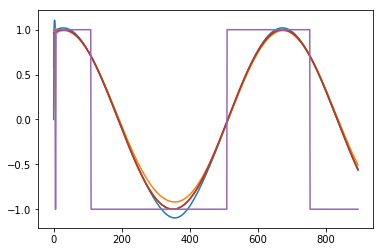

In [360]:
series_model.reset_states() # reset cells
predicted = series_model.predict(x_train, batch_size=batch_size)
plt.plot(predicted[:])
plt.plot(y_train[:])
#plt.plot(np.sign(y_train[:,0] - y_train[:,1]))
plt.plot(np.sign(predicted[:,0] - predicted[:,1]))

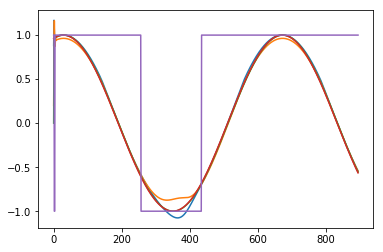

In [363]:
series_model.reset_states() # reset cells
predicted = series_model.predict(x_train, batch_size=batch_size)
plt.plot(predicted[:])
plt.plot(y_train[:])
#plt.plot(np.sign(y_train[:,0] - y_train[:,1]))
plt.plot(np.sign(predicted[:,0] - predicted[:,1]))

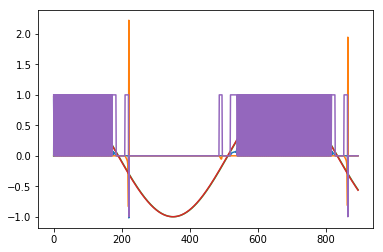

In [366]:
series_model.reset_states() # reset cells
predicted = series_model.predict(x_train, batch_size=batch_size)
plt.plot(predicted[:])
plt.plot(y_train[:])
#plt.plot(np.sign(y_train[:,0] - y_train[:,1]))
plt.plot(np.sign(predicted[:,0] - predicted[:,1]))

EOF
-------------------